# Connect DRIVE

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


# Load Lib


In [ ]:
seed=42

import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 1000

#Set split sizes
SPLITS_SIZE = 300

NUM_CLASSES=5

# Load Data


In [ ]:
data = np.load("no_alien_dataset_3colors.npz")


X_train = data["train_images_set"]
y_train = data["train_labels_set"].astype(int)

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 3)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128, 3)


In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[...] / 255.0
X_test = X_test[...] / 255.0
y_train=y_train[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

output_shape=[X_train.shape[1],X_train.shape[2],num_classes]

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Output shape: {output_shape}")

Input shape: (64, 128, 3)
Number of classes: 5
Output shape: [64, 128, 5]


In [ ]:
#ATTENZIONE RUN NO MORE THAN ONCE


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=seed, shuffle=True
)

print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {len(X_test)}")

Data splitted!

Number of images:
Train: (2205, 64, 128, 3)
Validation: (300, 64, 128, 3)
Test: 10022


 ###   *Useful Functions*

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()


In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset from preloaded images and labels.
    """
    # Create dataset from images and labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)


    augmentations = [
    random_flip,               # Flip orizzontale
    # random_vertical_flip,      # Flip verticale
    # random_rotation,           # Rotazione casuale
    # random_brightness,         # Luminosità casuale
    # random_contrast         # Contrasto casuale
    #,elastic_transform
    ]

    if augment:
        dataset = dataset.map(
            lambda x, y: apply_random_augmentations(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


# Data Augmentation

In [ ]:
@tf.function
def apply_random_augmentations(image, label, seed=None):
    """Randomly select and apply three augmentations."""

    augmentations = [
    random_flip,               # Flip orizzontale
    random_vertical_flip,     # Flip verticale
    random_rotation,           # Rotazione casuale
    random_brightness,         # Luminosità casuale
    random_contrast         # Contrasto casuale
    ,elastic_transform
    ]

    if seed is None:
        seed = np.random.randint(0, 1000000)
    selected_augmentations = np.random.choice(augmentations, size=1, replace=False)  # Pick 3 random augmentations
    for aug_fn in selected_augmentations:
        image, label = aug_fn(image, label)
    return image, label

# Lista delle trasformazioni


In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
@tf.function
def random_vertical_flip(image, label, seed=None):
    """Consistent random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label


In [ ]:
@tf.function
def random_rotation(image, label,max_angle=30,seed=None):
    """Consistent random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([])

    angle=tf.random.uniform([],-max_angle,max_angle,seed=seed)
    angle_rad=tf.cast(angle,tf.float32)* tf.constant(3.141592653589793 / 180.0)

    image=tfa.image.rotate(image,angle_rad,interpolation="BILINEAR")
    label=tfa.image.rotate(label,angle_rad,interpolatino='NEAREST')
    return image, label


In [ ]:
@tf.function
def random_brightness(image, label,max_delta=0.2, seed=None):
    """Apply random contrast adjustment to the image."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    brightness_factor = tf.random.uniform([], maxval=max_delta, seed=seed)  # Random factor in range [lower, upper]
    image = tf.image.adjust_brightness(image, brightness_factor)
    return image, label

In [ ]:
@tf.function
def random_contrast(image, label, lower=0.8, upper=1.2, seed=None):
    """Apply random contrast adjustment to the image."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    contrast_factor = tf.random.uniform([], lower, upper, seed=seed)  # Random factor in range [lower, upper]
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image, label

In [ ]:
import scipy.ndimage as ndi

def elastic_transform(image, label, alpha, sigma, seed=None):
    if seed is not None:
        np.random.seed(seed)
    random_state = np.random.RandomState(None)

    shape = image.shape[:2]
    dx = ndi.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = ndi.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    image = ndi.map_coordinates(image, indices, order=1, mode="reflect").reshape(shape + (image.shape[2],))
    label = ndi.map_coordinates(label, indices, order=0, mode="reflect").reshape(shape + (label.shape[2],))

    return image, label


In [ ]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape: (64, 128, 3)
Images shape: (64, 64, 128, 3)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int64'>


Visualizing examples from the training set:


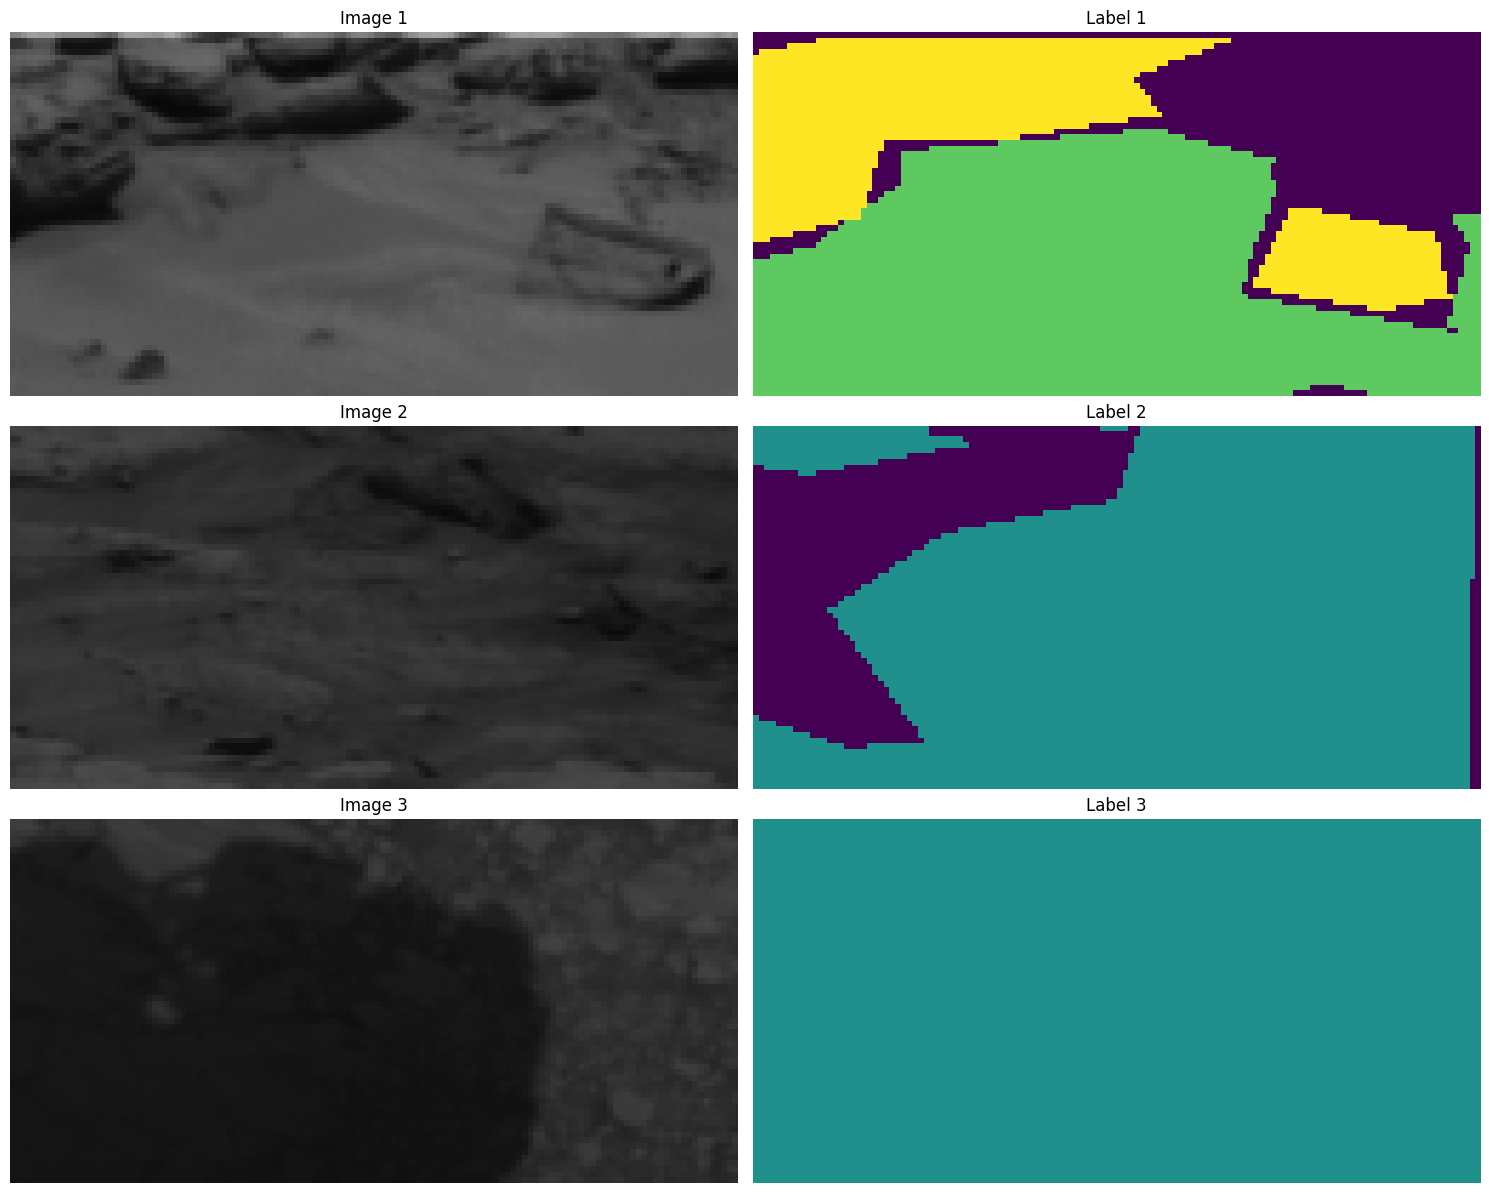

In [ ]:
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

# Model

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        """
        Callback per visualizzare le predizioni del modello durante l'addestramento.

        Args:
            image (numpy array o tf.Tensor): Immagine da utilizzare per la predizione.
            label (numpy array o tf.Tensor): Maschera di ground truth associata.
            frequency (int): Frequenza (in epoche) per la visualizzazione.
        """
        super().__init__()
        self.image = image  # Immagine in memoria
        self.label = label  # Label in memoria
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza ogni "frequency" epoche
            # Espandi la dimensione del batch per la predizione
            image_batch = tf.expand_dims(self.image, 0)
            pred = self.model.predict(image_batch, verbose=0)

            # Estrai la classe predetta per ogni pixel
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Creazione della colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Immagine di input
            plt.subplot(1, 3, 1)
            plt.imshow(self.image)
            plt.title("Input Image")
            plt.axis('off')

            # Maschera di ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Maschera predetta
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


## PAOLO

### Loss function

In [ ]:
def focal_loss_segmentation(gamma=2.0, alpha=[0.2, 0.2, 0.2, 0.2, 0.30]):
    def loss_function(y_true, y_pred):
        # Converti y_true in one-hot encoding
        num_classes = y_pred.shape[-1]
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

        # Rimuovi la dimensione superflua da y_true_one_hot
        y_true_one_hot = tf.squeeze(y_true_one_hot, axis=-2)  # Rimuove l'asse con dimensione 1

        # Clip di y_pred per evitare log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Pesatura delle classi con alpha
        alpha_tensor = tf.constant(alpha, dtype=tf.float32)
        alpha_weights = tf.reduce_sum(alpha_tensor * y_true_one_hot, axis=-1, keepdims=True)  # Aggiungi una dimensione

        # Calcola cross-entropy e pesi focali
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        weights = alpha_weights * tf.math.pow(1 - y_pred, gamma)
        focal_loss = weights * cross_entropy

        # Media sui pixel e batch
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss_function


In [ ]:
import tensorflow.keras.backend as K

def boundary_loss(y_true, y_pred, weight=1.0):
    """
    Funzione di perdita per la penalizzazione degli errori nei bordi.
    Gestisce le etichette multiclasse separando ogni classe.
    """
    def get_edges(y):
        # Applichiamo un filtro Sobel per ottenere i bordi
        sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
        sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)

        sobel_x = tf.reshape(sobel_x, [3, 3, 1, 1])
        sobel_y = tf.reshape(sobel_y, [3, 3, 1, 1])

        edges_x = tf.nn.conv2d(y, sobel_x, strides=[1, 1, 1, 1], padding='SAME')
        edges_y = tf.nn.conv2d(y, sobel_y, strides=[1, 1, 1, 1], padding='SAME')

        return tf.sqrt(edges_x**2 + edges_y**2)

    # Crea un tensor vuoto per accumulare il risultato dei bordi
    edges_true_total = tf.zeros_like(y_true, dtype=tf.float32)
    edges_pred_total = tf.zeros_like(y_pred, dtype=tf.float32)

    # Calcola i bordi per ogni classe separatamente
    for i in range(y_true.shape[-1]):  # y_true.shape[-1] è il numero di classi
        edges_true_class = get_edges(y_true[..., i:i+1])  # Applica ai bordi di una classe alla volta
        edges_pred_class = get_edges(y_pred[..., i:i+1])  # Applica ai bordi di una classe alla volta

        edges_true_total += edges_true_class
        edges_pred_total += edges_pred_class

    # Calcoliamo la perdita come la somma delle differenze tra i bordi
    loss = K.mean(K.abs(edges_true_total - edges_pred_total))

    return weight * loss


In [ ]:
def polygon_boundary_loss(y_true, y_pred, weight=1.0):
    """
    Funzione di perdita per la penalizzazione degli errori nei bordi,
    enfatizzando le caratteristiche angolari dei bordi, per suggerire bordi poligonali.
    """

    def get_edges(y):
        # Applichiamo il filtro Sobel per ottenere i bordi orizzontali e verticali
        sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
        sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)

        sobel_x = tf.reshape(sobel_x, [3, 3, 1, 1])
        sobel_y = tf.reshape(sobel_y, [3, 3, 1, 1])

        edges_x = tf.nn.conv2d(y, sobel_x, strides=[1, 1, 1, 1], padding='SAME')
        edges_y = tf.nn.conv2d(y, sobel_y, strides=[1, 1, 1, 1], padding='SAME')

        return tf.sqrt(edges_x**2 + edges_y**2)

    def get_angles(y):
        """Calcola l'orientamento dei bordi usando il gradiente angolare."""
        sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
        sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)

        sobel_x = tf.reshape(sobel_x, [3, 3, 1, 1])
        sobel_y = tf.reshape(sobel_y, [3, 3, 1, 1])

        grad_x = tf.nn.conv2d(y, sobel_x, strides=[1, 1, 1, 1], padding='SAME')
        grad_y = tf.nn.conv2d(y, sobel_y, strides=[1, 1, 1, 1], padding='SAME')

        angles = tf.atan2(grad_y, grad_x)  # Calcola l'angolo del gradiente in ogni punto
        return angles

    # Calcoliamo i bordi e gli angoli per le etichette vere e quelle predette
    edges_true_total = tf.zeros_like(y_true, dtype=tf.float32)
    edges_pred_total = tf.zeros_like(y_pred, dtype=tf.float32)
    angles_true_total = tf.zeros_like(y_true, dtype=tf.float32)
    angles_pred_total = tf.zeros_like(y_pred, dtype=tf.float32)

    for i in range(y_true.shape[-1]):  # Iteriamo per ogni classe
        edges_true_class = get_edges(y_true[..., i:i+1])
        edges_pred_class = get_edges(y_pred[..., i:i+1])

        angles_true_class = get_angles(y_true[..., i:i+1])
        angles_pred_class = get_angles(y_pred[..., i:i+1])

        edges_true_total += edges_true_class
        edges_pred_total += edges_pred_class

        angles_true_total += angles_true_class
        angles_pred_total += angles_pred_class

    # Penalizzazione sugli errori nei bordi (differenza assoluta)
    edge_loss = K.mean(K.abs(edges_true_total - edges_pred_total))

    # Penalizzazione sugli angoli (differenza assoluta tra gli angoli)
    angle_loss = K.mean(K.abs(angles_true_total - angles_pred_total))

    # Sommiamo le perdite per i bordi e gli angoli
    loss = edge_loss + angle_loss

    # Applicazione del peso alla perdita finale
    return weight * loss


In [ ]:
def combined_loss(y_true, y_pred, focal_weight=1.0, boundary_weight=1.0):
    focal_loss = focal_loss_segmentation()(y_true, y_pred)
    boundary_loss_value = boundary_loss(y_true, y_pred)
    return focal_weight * focal_loss + boundary_weight * boundary_loss_value

### CODE AVAST

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
# prompt: Genera una funzione che crea un ritorna un modello unet, non deve compilarlo. Deve esser possibile modificare i parametri. Esiste già la funzione per creare unet block

from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model

def create_unet_model(input_shape, num_classes, num_layers=4, start_filters=64, stack=2):
    """
    Creates a U-Net model without compiling it.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of classes for segmentation.
        num_layers (int): Number of layers in the encoder/decoder path.
        start_filters (int): Number of filters for the first convolutional layer.
        stack (int): Number of convolutional layers per block.
    Returns:
        tfk.Model: The U-Net model.
    """
    inputs = tfkl.Input(shape=input_shape)

    # Encoder
    skips = []
    x = inputs
    for i in range(num_layers):
        x = unet_block(x, start_filters * (2**i), name=f'encoder_block_{i}_')
        skips.append(x)
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'maxpool_{i}_')(x)

    # Bottleneck
    x = unet_block(x, start_filters * (2**num_layers), name='bottleneck_')

    # Decoder
    for i in range(num_layers - 1, -1, -1):
        x = tfkl.Conv2DTranspose(start_filters * (2**i), kernel_size=(2, 2), strides=(2, 2), padding='same', name=f'upsample_{i}_')(x)
        x = tfkl.Concatenate(axis=-1, name=f'concat_{i}_')([x, skips[i]])
        x = unet_block(x, start_filters * (2**i), name=f'decoder_block_{i}_')

    # Output
    outputs = tfkl.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='unet_model')
    return model

In [ ]:
# prompt: Usando la funzione di sopra, creami due unet concatenate. La prima deve essere più semplice, la seconda deve rifinire i risultati, prendendo come input sia le immagini che le classi.

def create_concatenated_unets(input_shape, num_classes):
    """Creates two concatenated U-Net models."""

    # First U-Net (simpler)
    unet1 = create_unet_model(input_shape, num_classes, num_layers=3, start_filters=32, stack=1)
    unet1_output = unet1.output
    # Second U-Net (refines results)
    #unet1_output_reshaped = tfkl.Reshape(input_shape[:-1] + (num_classes,))(unet1_output)
    # Input includes both images and class predictions from the first U-Net
    combined_input = tfkl.Input(shape=input_shape[:-1] + (num_classes + input_shape[-1],)) # Corrected shape: (height, width, classes + original channels)
    #Concatenate the two inputs
    x = combined_input

    #Second unet
    skips2 = []
    for i in range(3):
        x = unet_block(x, 32 * (2**i), name=f'encoder2_block_{i}_')
        skips2.append(x)
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'maxpool2_{i}_')(x)
    # Bottleneck
    x = unet_block(x, 32 * (2**3), name='bottleneck2_')

    # Decoder
    for i in range(2, -1, -1):
        x = tfkl.Conv2DTranspose(32 * (2**i), kernel_size=(2, 2), strides=(2, 2), padding='same', name=f'upsample2_{i}_')(x)
        x = tfkl.Concatenate(axis=-1, name=f'concat2_{i}_')([x, skips2[i]])
        x = unet_block(x, 32 * (2**i), name=f'decoder2_block_{i}_')

    # Output
    outputs2 = tfkl.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', name='output_layer2')(x)

    unet2 = Model(inputs=combined_input, outputs=outputs2, name='unet_model2')


    return unet1, unet2

In [ ]:
# prompt: Crea le due unet concatenate con la funzione appena create. Abbiamo già input_shape, numero classi


# Esempio di utilizzo: crea e visualizza i due modelli U-Net concatenati
unet1, unet2 = create_concatenated_unets(input_shape, NUM_CLASSES)

In [ ]:
# prompt: Compila i modelli unet1 e unet2

print("Compiling model...")


# Compila il primo modello U-Net
unet1.compile(
    optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.10),  # Utilizza la loss combinata
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Compila il secondo modello U-Net
unet2.compile(
    optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.20),  # Utilizza la loss combinata
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

print("Models compiled!")

# Stampa il riepilogo dei modelli per verificare la corretta costruzione
unet1.summary()
unet2.summary()

Compiling model...
Models compiled!


Model: "unet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_conv1     │ (None, 64, 128, 32)    │            896 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_bn1       │ (None, 64, 128, 32)    │            128 │ encoder_block_0_conv1… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_activati… │ (None, 64, 128, 32)    │              0 │ encoder_block_0_bn1[0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_conv2     │ (None, 64, 128, 32)    │          9,248 │ encoder_block_0_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_bn2       │ (None, 64, 128, 32)    │            128 │ encoder_block_0_conv2… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_activati… │ (None, 64, 128, 32)    │              0 │ encoder_block_0_bn2[0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_0_ (MaxPooling2D) │ (None, 32, 64, 32)     │              0 │ encoder_block_0_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1_conv1     │ (None, 32, 64, 64)     │         18,496 │ maxpool_0_[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1_bn1       │ (None, 32, 64, 64)     │            256 │ encoder_block_1_conv1… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1_activati… │ (None, 32, 64, 64)     │              0 │ encoder_block_1_bn1[0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1_conv2     │ (None, 32, 64, 64)     │         36,928 │ encoder_block_1_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1_bn2       │ (None, 32, 64, 64)     │            256 │ encoder_block_1_conv2… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1_activati… │ (None, 32, 64, 64)     │              0 │ encoder_block_1_bn2[0… │
│ (Activation)         

 Total params: 1,931,365 (7.37 MB)

 Trainable params: 1,928,549 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

Model: "unet_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 8)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_0_conv1    │ (None, 64, 128, 32)    │          2,336 │ input_layer_1[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_0_bn1      │ (None, 64, 128, 32)    │            128 │ encoder2_block_0_conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_0_activat… │ (None, 64, 128, 32)    │              0 │ encoder2_block_0_bn1[… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_0_conv2    │ (None, 64, 128, 32)    │          9,248 │ encoder2_block_0_acti… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_0_bn2      │ (None, 64, 128, 32)    │            128 │ encoder2_block_0_conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_0_activat… │ (None, 64, 128, 32)    │              0 │ encoder2_block_0_bn2[… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool2_0_               │ (None, 32, 64, 32)     │              0 │ encoder2_block_0_acti… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_1_conv1    │ (None, 32, 64, 64)     │         18,496 │ maxpool2_0_[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_1_bn1      │ (None, 32, 64, 64)     │            256 │ encoder2_block_1_conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_1_activat… │ (None, 32, 64, 64)     │              0 │ encoder2_block_1_bn1[… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_1_conv2    │ (None, 32, 64, 64)     │         36,928 │ encoder2_block_1_acti… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_block_1_bn2      │ (None, 32, 64, 64)     │            256 │ encoder2_block_1_conv… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,932,805 (7.37 MB)

 Trainable params: 1,929,989 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[4], y_val[4])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.72,
                              patience=8)

checkpoint1 = ModelCheckpoint('ConcatUNET1.keras',
                             monitor='val_accuracy',  # Monitora la validazione accuracy
                             save_best_only=True,     # Salva solo il miglior modello
                             mode='max',              # Il miglior modello è quello con la max accuracy
                             verbose=1)               # Mostra un messaggio ogni volta che viene salvato il modello

checkpoint2 = ModelCheckpoint('ConcatUNET2.keras',
                             monitor='val_accuracy',  # Monitora la validazione accuracy
                             save_best_only=True,     # Salva solo il miglior modello
                             mode='max',              # Il miglior modello è quello con la max accuracy
                             verbose=1)               # Mostra un messaggio ogni volta che viene salvato il modello

In [ ]:
# prompt: Train the models

# Training of the first model
'''history1 = unet1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint1, viz_callback],
    #class_weight=class_weights_dict
)

# Load the best weights for unet1'''
unet1.load_weights('ConcatUNET1.keras')


# Create a new dataset for the second U-Net, including the predictions of the first one
def make_dataset_unet2(X, y, unet1, batch_size=32, shuffle=False):
    # Generate predictions with the first U-Net
    predictions = unet1.predict(X, batch_size=batch_size, verbose=1)
    # Combine images and predictions for input to second U-Net
    combined_data = np.concatenate((X, predictions), axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices((combined_data, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset_2 = make_dataset_unet2(X_train, y_train, unet1, batch_size=BATCH_SIZE, shuffle=True)
val_dataset_2 = make_dataset_unet2(X_val, y_val, unet1, batch_size=BATCH_SIZE)

# Training of the second model
history2 = unet2.fit(
    train_dataset_2,
    validation_data=val_dataset_2,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint2],
    #class_weight=class_weights_dict
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 130 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7599 - loss: 0.1892 - mean_iou: 0.4568
Epoch 1: val_accuracy improved from -inf to 0.75054, saving model to ConcatUNET2.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.20),  # Utilizza la loss combinata

  return {key: serialize_keras_object(value) for key, value in obj.items()}


35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 879ms/step - accuracy: 0.7622 - loss: 0.1884 - mean_iou: 0.4588 - val_accuracy: 0.7505 - val_loss: 0.2519 - val_mean_iou: 0.4785 - learning_rate: 0.0010
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8772 - loss: 0.1397 - mean_iou: 0.5699
Epoch 2: val_accuracy did not improve from 0.75054
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8773 - loss: 0.1396 - mean_iou: 0.5699 - val_accuracy: 0.7474 - val_loss: 0.1909 - val_mean_iou: 0.4359 - learning_rate: 0.0010
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8826 - loss: 0.1323 - mean_iou: 0.5761
Epoch 3: val_accuracy did not improve from 0.75054
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.8826 - loss: 0.1323 - mean_iou: 0.5761 - val_accuracy: 0.7288 - val_loss: 0.1904 - val_mean_iou: 0.4162 - learning_rate: 0.0010
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8820 - loss: 0.1307 - mean_iou: 0.5774
Epoch 4: val_accuracy did n

In [ ]:
# prompt: Salva il modello finale
unet1.save('unet1_model.keras')
print("Final model saved successfully!")
# Save the final model (unet2)
unet2.save('unet2_model.keras')
print("Final model saved successfully!")
del unet1
del unet2

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.10),  # Utilizza la loss combinata

  return {key: serialize_keras_object(value) for key, value in obj.items()}


Final model saved successfully!
Final model saved successfully!


### PROVA LIB

In [ ]:
!pip install keras_unet_collection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[4], y_val[4])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.72,
                              patience=8)

checkpoint1 = ModelCheckpoint('UNET1.keras',
                             monitor='val_accuracy',  # Monitora la validazione accuracy
                             save_best_only=True,     # Salva solo il miglior modello
                             mode='max',              # Il miglior modello è quello con la max accuracy
                             verbose=0)               # Mostra un messaggio ogni volta che viene salvato il modello


checkpoint2 = ModelCheckpoint('UNET2.keras',
                             monitor='val_accuracy',  # Monitora la validazione accuracy
                             save_best_only=True,     # Salva solo il miglior modello
                             mode='max',              # Il miglior modello è quello con la max accuracy
                             verbose=0)               # Mostra un messaggio ogni volta che viene salvato il modello

In [ ]:
# prompt: Usando la libreria keras_unet_collection, voglio due unet concatenate, una più semplice, una che vada nel dettaglio, una attention net

from keras_unet_collection import models, losses


# Assuming input_shape and NUM_CLASSES are defined elsewhere in your code
# Example:

def create_concatenated_unets(input_shape, num_classes):
    """Creates two concatenated U-Net models with attention gate."""

    # First U-Net (simpler)
    unet1 = models.unet_2d((input_shape[0], input_shape[1], input_shape[2]), filter_num=[16, 32, 64, 128], n_labels=NUM_CLASSES, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=True, pool=True, unpool=True, name='unet1')

    # Second U-Net (detailed with attention)
    unet2_input = tfkl.Input(shape=input_shape[:-1] + (num_classes + input_shape[-1],))

    unet2 = models.unet_3plus_2d((input_shape[0], input_shape[1], num_classes + input_shape[-1]), filter_num_down=[32, 64, 128, 256], filter_num_skip=[256, 128, 64, 32], deep_supervision = False,n_labels=NUM_CLASSES, stack_num_down=2, stack_num_up=2, activation='LeakyReLU', output_activation='Softmax', batch_norm=True, pool=True, unpool=True, name='unet2')
    unet2_output = unet2(unet2_input)

    return unet1, tfk.Model(inputs=unet2_input, outputs=unet2_output)

# Example usage
unet1, unet2 = create_concatenated_unets(input_shape, NUM_CLASSES)

# Compile the models
unet1.compile(optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.10),  # Utilizza la loss combinata,
              metrics=['accuracy', MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])])


unet2.compile(optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.20),  # Utilizza la loss combinata,
              metrics=['accuracy', MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])])

unet1.summary()
unet2.summary()

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [256, 128, 64, 32]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 128


Model: "unet1_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 64, 128, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down0_0 (Conv2D)    │ (None, 64, 128, 16)    │            432 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down0_0_bn          │ (None, 64, 128, 16)    │             64 │ unet1_down0_0[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down0_0_activation  │ (None, 64, 128, 16)    │              0 │ unet1_down0_0_bn[0][0] │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down0_1 (Conv2D)    │ (None, 64, 128, 16)    │          2,304 │ unet1_down0_0_activat… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down0_1_bn          │ (None, 64, 128, 16)    │             64 │ unet1_down0_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down0_1_activation  │ (None, 64, 128, 16)    │              0 │ unet1_down0_1_bn[0][0] │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down1_encode_maxpo… │ (None, 32, 64, 16)     │              0 │ unet1_down0_1_activat… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down1_conv_0        │ (None, 32, 64, 32)     │          4,608 │ unet1_down1_encode_ma… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down1_conv_0_bn     │ (None, 32, 64, 32)     │            128 │ unet1_down1_conv_0[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down1_conv_0_activ… │ (None, 32, 64, 32)     │              0 │ unet1_down1_conv_0_bn… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down1_conv_1        │ (None, 32, 64, 32)     │          9,216 │ unet1_down1_conv_0_ac… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down1_conv_1_bn     │ (None, 32, 64, 32)     │            128 │ unet1_down1_conv_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet1_down1_conv_1_activ… │ (None, 32, 64, 32)     │              0 │ unet1_down1_conv_1_bn… │
│ (ReLU)               

 Total params: 538,309 (2.05 MB)

 Trainable params: 536,677 (2.05 MB)

 Non-trainable params: 1,632 (6.38 KB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 64, 128, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 64, 128, 5)          │       5,024,645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,024,645 (19.17 MB)

 Trainable params: 5,018,501 (19.14 MB)

 Non-trainable params: 6,144 (24.00 KB)

Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.3483 - loss: 0.2540 - mean_iou: 0.1827

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:               loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.10),  # Utilizza la loss combinata,

  return {key: serialize_keras_object(value) for key, value in obj.items()}


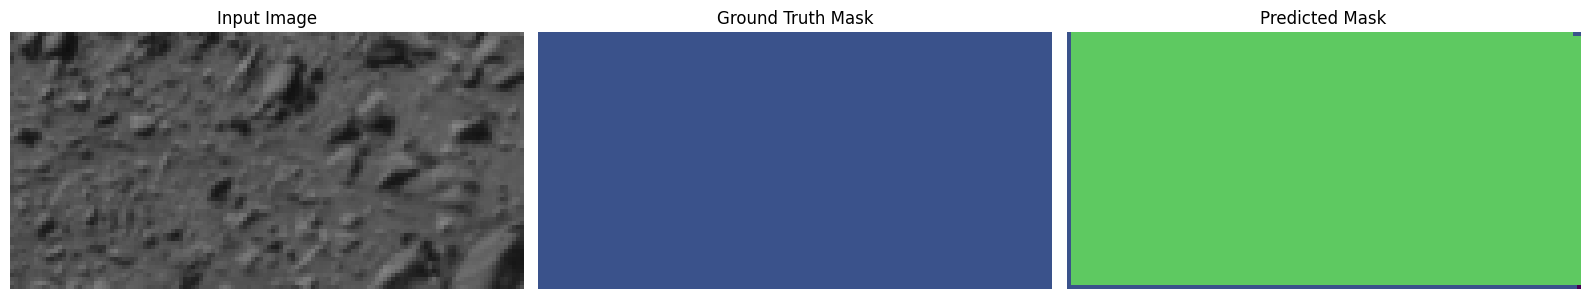

37/37 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3499 - loss: 0.2533 - mean_iou: 0.1835 - val_accuracy: 0.1849 - val_loss: 0.2813 - val_mean_iou: 0.0518 - learning_rate: 0.0010
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5275 - loss: 0.1899 - mean_iou: 0.2816 - val_accuracy: 0.1828 - val_loss: 0.4481 - val_mean_iou: 0.0494 - learning_rate: 0.0010
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.5990 - loss: 0.1696 - mean_iou: 0.3294 - val_accuracy: 0.1825 - val_loss: 0.5446 - val_mean_iou: 0.0490 - learning_rate: 0.0010
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6079 - loss: 0.1627 - mean_iou: 0.3336 - val_accuracy: 0.1835 - val_loss: 0.3858 - val_mean_iou: 0.0499 - learning_rate: 0.0010
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.6149 - loss: 0.1575 - mean_iou: 0.3425 - val_accuracy: 0.1821 - val_loss: 0.6202 - val_mean_iou: 0.0485 - learning_rate: 0.0010
Epoch 6/1000
36/37 ━━━━━━━━━━━━━━━━━━━

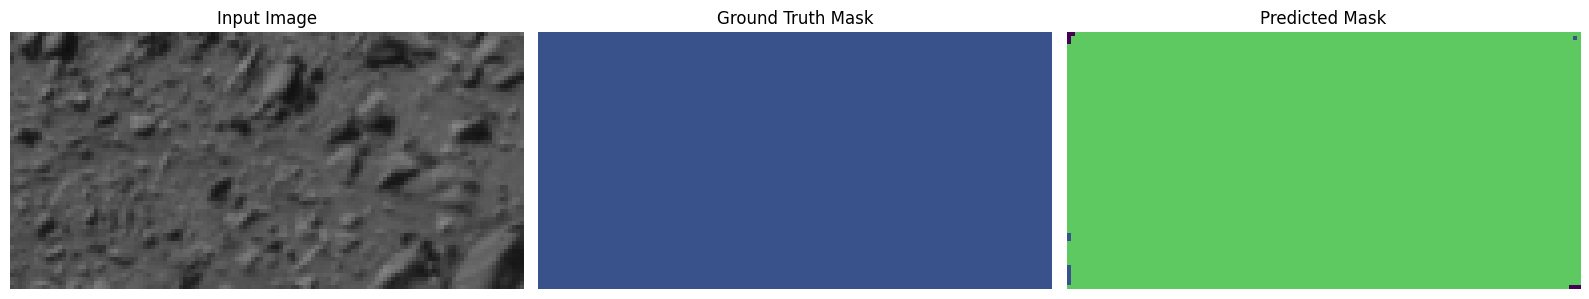

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6551 - loss: 0.1472 - mean_iou: 0.3754 - val_accuracy: 0.1815 - val_loss: 0.5914 - val_mean_iou: 0.0480 - learning_rate: 0.0010
Epoch 7/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6339 - loss: 0.1477 - mean_iou: 0.3565 - val_accuracy: 0.1813 - val_loss: 0.5851 - val_mean_iou: 0.0479 - learning_rate: 0.0010
Epoch 8/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.6528 - loss: 0.1428 - mean_iou: 0.3801 - val_accuracy: 0.2217 - val_loss: 0.4103 - val_mean_iou: 0.0740 - learning_rate: 0.0010
Epoch 9/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.6706 - loss: 0.1394 - mean_iou: 0.3966 - val_accuracy: 0.1825 - val_loss: 0.5351 - val_mean_iou: 0.0485 - learning_rate: 0.0010
Epoch 10/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.6736 - loss: 0.1372 - mean_iou: 0.3940 - val_accuracy: 0.3729 - val_loss: 0.3072 - val_mean_iou: 0.1631 - learning_rate: 7.2000e-04
Epoch 11/1000
36/37 ━━━━━━━━━

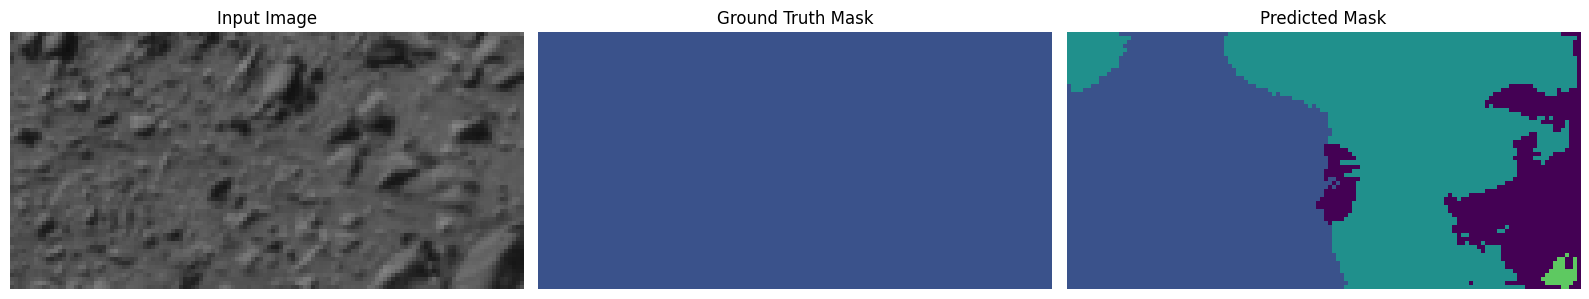

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.6846 - loss: 0.1329 - mean_iou: 0.4054 - val_accuracy: 0.3327 - val_loss: 0.3081 - val_mean_iou: 0.1399 - learning_rate: 7.2000e-04
Epoch 12/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.6963 - loss: 0.1310 - mean_iou: 0.4183 - val_accuracy: 0.3569 - val_loss: 0.3021 - val_mean_iou: 0.1577 - learning_rate: 7.2000e-04
Epoch 13/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.6860 - loss: 0.1322 - mean_iou: 0.4081 - val_accuracy: 0.5060 - val_loss: 0.2098 - val_mean_iou: 0.2728 - learning_rate: 7.2000e-04
Epoch 14/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7029 - loss: 0.1268 - mean_iou: 0.4240 - val_accuracy: 0.4866 - val_loss: 0.2234 - val_mean_iou: 0.2211 - learning_rate: 7.2000e-04
Epoch 15/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.7098 - loss: 0.1278 - mean_iou: 0.4244 - val_accuracy: 0.5923 - val_loss: 0.1733 - val_mean_iou: 0.3347 - learning_rate: 7.2000e-04
Epoch 16/1

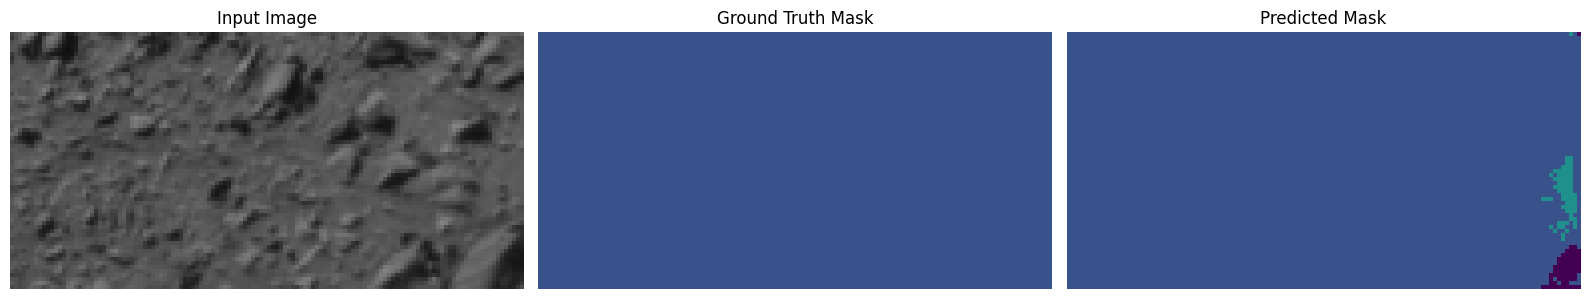

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7062 - loss: 0.1274 - mean_iou: 0.4221 - val_accuracy: 0.6654 - val_loss: 0.1448 - val_mean_iou: 0.3917 - learning_rate: 7.2000e-04
Epoch 17/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7188 - loss: 0.1229 - mean_iou: 0.4371 - val_accuracy: 0.6628 - val_loss: 0.1366 - val_mean_iou: 0.4150 - learning_rate: 7.2000e-04
Epoch 18/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.7133 - loss: 0.1233 - mean_iou: 0.4309 - val_accuracy: 0.6184 - val_loss: 0.1814 - val_mean_iou: 0.3481 - learning_rate: 7.2000e-04
Epoch 19/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7117 - loss: 0.1245 - mean_iou: 0.4278 - val_accuracy: 0.7322 - val_loss: 0.1228 - val_mean_iou: 0.4526 - learning_rate: 7.2000e-04
Epoch 20/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7188 - loss: 0.1222 - mean_iou: 0.4344 - val_accuracy: 0.7040 - val_loss: 0.1307 - val_mean_iou: 0.3979 - learning_rate: 7.2000e-04
Epoch 21/1

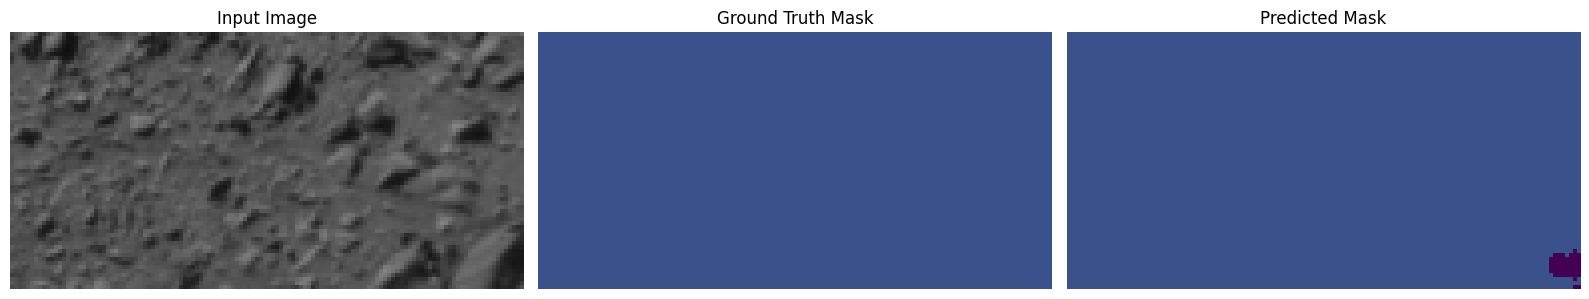

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7195 - loss: 0.1209 - mean_iou: 0.4365 - val_accuracy: 0.6551 - val_loss: 0.1530 - val_mean_iou: 0.3559 - learning_rate: 7.2000e-04
Epoch 22/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7212 - loss: 0.1208 - mean_iou: 0.4376 - val_accuracy: 0.6766 - val_loss: 0.1368 - val_mean_iou: 0.3497 - learning_rate: 7.2000e-04
Epoch 23/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7253 - loss: 0.1182 - mean_iou: 0.4454 - val_accuracy: 0.7104 - val_loss: 0.1287 - val_mean_iou: 0.4326 - learning_rate: 7.2000e-04
Epoch 24/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.7453 - loss: 0.1135 - mean_iou: 0.4644 - val_accuracy: 0.7141 - val_loss: 0.1269 - val_mean_iou: 0.4370 - learning_rate: 7.2000e-04
Epoch 25/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7365 - loss: 0.1160 - mean_iou: 0.4537 - val_accuracy: 0.6934 - val_loss: 0.1366 - val_mean_iou: 0.4086 - learning_rate: 7.2000e-04
Epoch 26/100

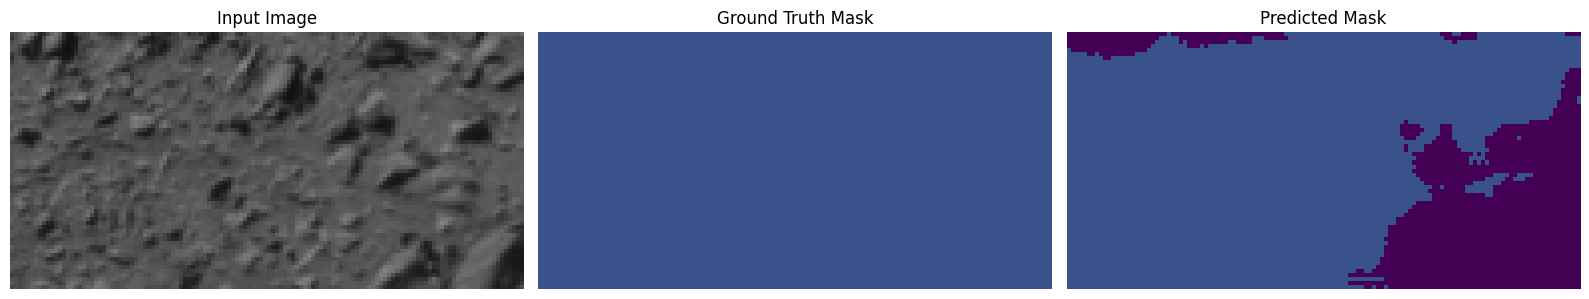

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.7392 - loss: 0.1147 - mean_iou: 0.4698 - val_accuracy: 0.6830 - val_loss: 0.1398 - val_mean_iou: 0.3909 - learning_rate: 7.2000e-04
Epoch 27/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.7438 - loss: 0.1129 - mean_iou: 0.4677 - val_accuracy: 0.7389 - val_loss: 0.1217 - val_mean_iou: 0.4491 - learning_rate: 7.2000e-04
Epoch 28/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7355 - loss: 0.1154 - mean_iou: 0.4555 - val_accuracy: 0.6730 - val_loss: 0.1384 - val_mean_iou: 0.4013 - learning_rate: 7.2000e-04
Epoch 29/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7508 - loss: 0.1108 - mean_iou: 0.4810 - val_accuracy: 0.6319 - val_loss: 0.1667 - val_mean_iou: 0.3662 - learning_rate: 7.2000e-04
Epoch 30/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7492 - loss: 0.1130 - mean_iou: 0.4871 - val_accuracy: 0.7357 - val_loss: 0.1202 - val_mean_iou: 0.4489 - learning_rate: 7.2000e-04
Epoch 31/100

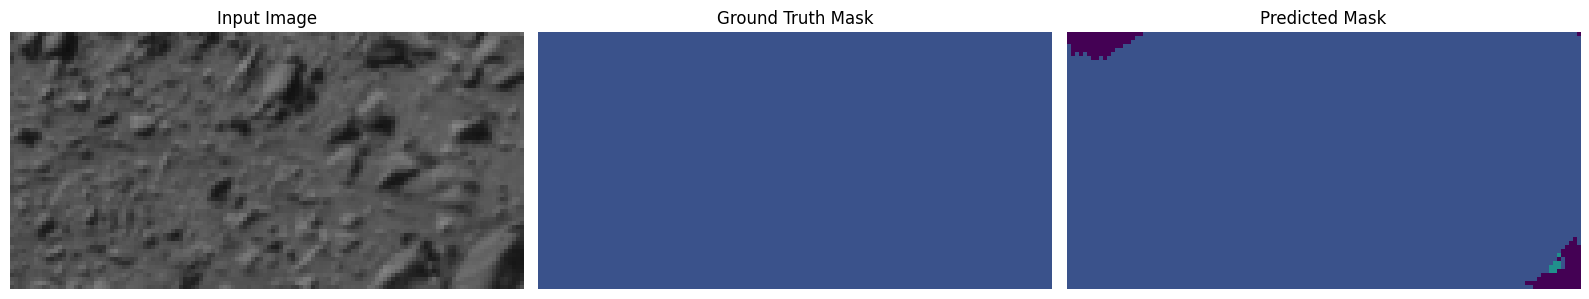

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.7510 - loss: 0.1102 - mean_iou: 0.4939 - val_accuracy: 0.6888 - val_loss: 0.1445 - val_mean_iou: 0.4229 - learning_rate: 7.2000e-04
Epoch 32/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7610 - loss: 0.1074 - mean_iou: 0.4820 - val_accuracy: 0.7612 - val_loss: 0.1192 - val_mean_iou: 0.4970 - learning_rate: 7.2000e-04
Epoch 33/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7696 - loss: 0.1067 - mean_iou: 0.5110 - val_accuracy: 0.6481 - val_loss: 0.1613 - val_mean_iou: 0.3820 - learning_rate: 7.2000e-04
Epoch 34/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.7635 - loss: 0.1062 - mean_iou: 0.5115 - val_accuracy: 0.7421 - val_loss: 0.1230 - val_mean_iou: 0.4737 - learning_rate: 7.2000e-04
Epoch 35/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7714 - loss: 0.1047 - mean_iou: 0.5202 - val_accuracy: 0.7631 - val_loss: 0.1153 - val_mean_iou: 0.4948 - learning_rate: 7.2000e-04
Epoch 36/

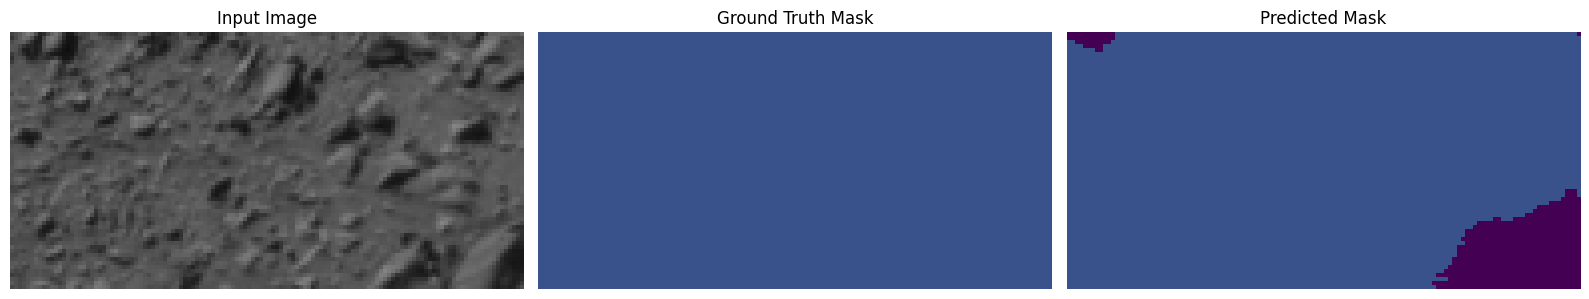

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7662 - loss: 0.1054 - mean_iou: 0.5199 - val_accuracy: 0.7451 - val_loss: 0.1247 - val_mean_iou: 0.4751 - learning_rate: 7.2000e-04
Epoch 37/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.7635 - loss: 0.1067 - mean_iou: 0.5099 - val_accuracy: 0.7530 - val_loss: 0.1182 - val_mean_iou: 0.4552 - learning_rate: 7.2000e-04
Epoch 38/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7746 - loss: 0.1028 - mean_iou: 0.5353 - val_accuracy: 0.7406 - val_loss: 0.1208 - val_mean_iou: 0.5177 - learning_rate: 7.2000e-04
Epoch 39/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7802 - loss: 0.1028 - mean_iou: 0.5675 - val_accuracy: 0.7501 - val_loss: 0.1185 - val_mean_iou: 0.4649 - learning_rate: 7.2000e-04
Epoch 40/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.7870 - loss: 0.1006 - mean_iou: 0.5786 - val_accuracy: 0.7651 - val_loss: 0.1150 - val_mean_iou: 0.5070 - learning_rate: 7.2000e-04
Epoch 41/

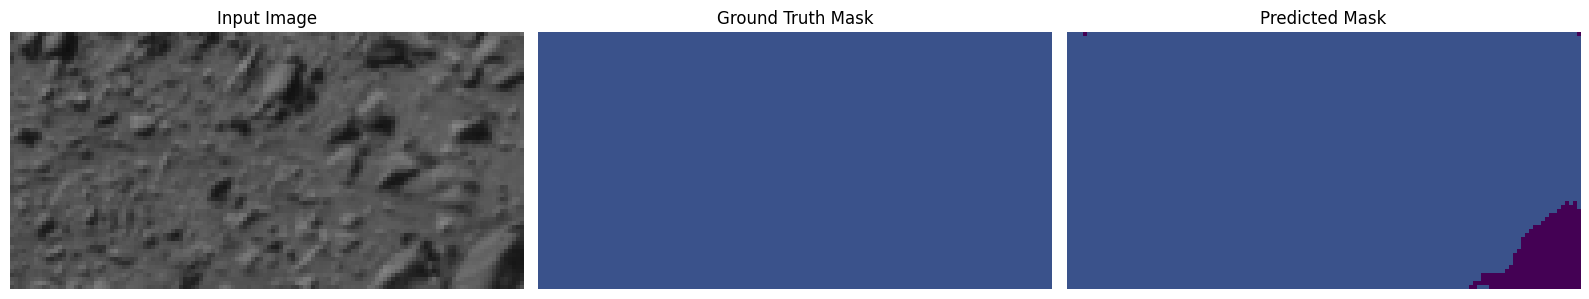

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7871 - loss: 0.1003 - mean_iou: 0.5689 - val_accuracy: 0.7657 - val_loss: 0.1187 - val_mean_iou: 0.5330 - learning_rate: 7.2000e-04
Epoch 42/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7700 - loss: 0.1036 - mean_iou: 0.5797 - val_accuracy: 0.7420 - val_loss: 0.1242 - val_mean_iou: 0.5142 - learning_rate: 7.2000e-04
Epoch 43/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7885 - loss: 0.0994 - mean_iou: 0.5799 - val_accuracy: 0.6993 - val_loss: 0.1428 - val_mean_iou: 0.4649 - learning_rate: 7.2000e-04
Epoch 44/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7880 - loss: 0.0996 - mean_iou: 0.5780 - val_accuracy: 0.7489 - val_loss: 0.1172 - val_mean_iou: 0.4895 - learning_rate: 7.2000e-04
Epoch 45/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7963 - loss: 0.0978 - mean_iou: 0.6016 - val_accuracy: 0.7325 - val_loss: 0.1255 - val_mean_iou: 0.5049 - learning_rate: 7.2000e-04
Epoch 46/10

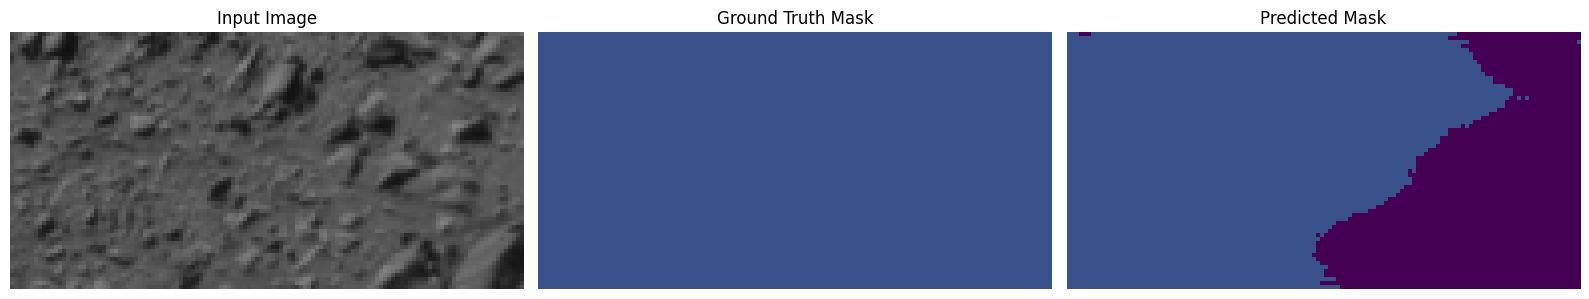

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7993 - loss: 0.0967 - mean_iou: 0.6076 - val_accuracy: 0.7484 - val_loss: 0.1224 - val_mean_iou: 0.5148 - learning_rate: 7.2000e-04
Epoch 47/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7993 - loss: 0.0960 - mean_iou: 0.6151 - val_accuracy: 0.7252 - val_loss: 0.1333 - val_mean_iou: 0.4722 - learning_rate: 7.2000e-04
Epoch 48/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7848 - loss: 0.1010 - mean_iou: 0.5834 - val_accuracy: 0.6830 - val_loss: 0.1502 - val_mean_iou: 0.4270 - learning_rate: 7.2000e-04
Epoch 49/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8020 - loss: 0.0941 - mean_iou: 0.5898 - val_accuracy: 0.7786 - val_loss: 0.1116 - val_mean_iou: 0.5209 - learning_rate: 5.1840e-04
Epoch 50/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.8107 - loss: 0.0927 - mean_iou: 0.6332 - val_accuracy: 0.7729 - val_loss: 0.1094 - val_mean_iou: 0.5450 - learning_rate: 5.1840e-04
Epoch 51/10

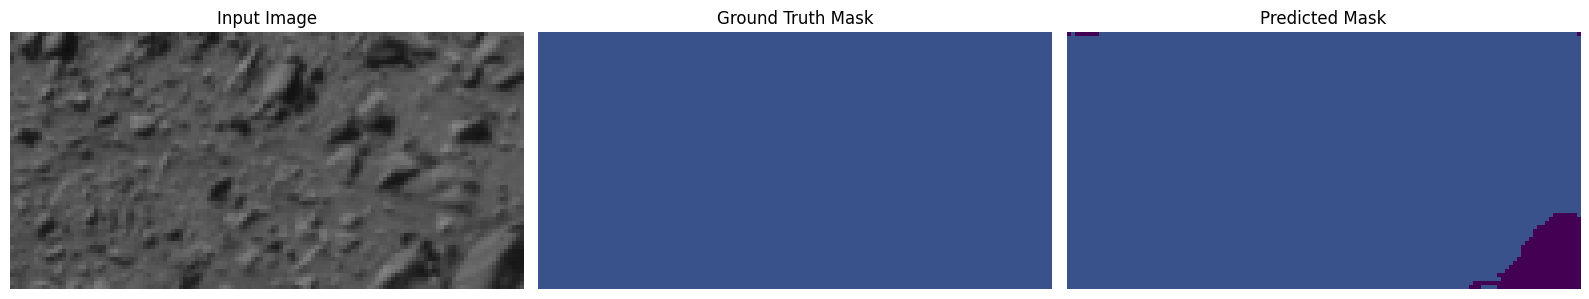

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.8184 - loss: 0.0901 - mean_iou: 0.6461 - val_accuracy: 0.7838 - val_loss: 0.1113 - val_mean_iou: 0.5410 - learning_rate: 5.1840e-04
Epoch 52/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.8126 - loss: 0.0919 - mean_iou: 0.6398 - val_accuracy: 0.7625 - val_loss: 0.1180 - val_mean_iou: 0.5266 - learning_rate: 5.1840e-04
Epoch 53/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8103 - loss: 0.0923 - mean_iou: 0.6445 - val_accuracy: 0.7450 - val_loss: 0.1159 - val_mean_iou: 0.5328 - learning_rate: 5.1840e-04
Epoch 54/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.8126 - loss: 0.0911 - mean_iou: 0.6384 - val_accuracy: 0.7578 - val_loss: 0.1189 - val_mean_iou: 0.5435 - learning_rate: 5.1840e-04
Epoch 55/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8215 - loss: 0.0891 - mean_iou: 0.6638 - val_accuracy: 0.7314 - val_loss: 0.1292 - val_mean_iou: 0.4734 - learning_rate: 5.1840e-04
Epoch 56/10

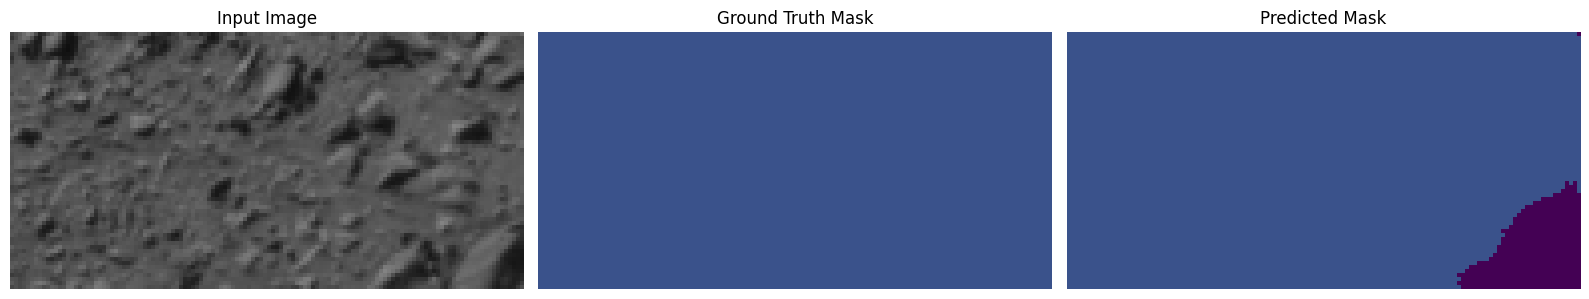

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.8106 - loss: 0.0916 - mean_iou: 0.6447 - val_accuracy: 0.7532 - val_loss: 0.1301 - val_mean_iou: 0.4988 - learning_rate: 5.1840e-04
Epoch 57/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8218 - loss: 0.0894 - mean_iou: 0.6475 - val_accuracy: 0.7686 - val_loss: 0.1179 - val_mean_iou: 0.5625 - learning_rate: 5.1840e-04
Epoch 58/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8139 - loss: 0.0914 - mean_iou: 0.6515 - val_accuracy: 0.7577 - val_loss: 0.1261 - val_mean_iou: 0.5689 - learning_rate: 5.1840e-04
Epoch 59/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8217 - loss: 0.0895 - mean_iou: 0.6680 - val_accuracy: 0.7633 - val_loss: 0.1206 - val_mean_iou: 0.5138 - learning_rate: 3.7325e-04
Epoch 60/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8299 - loss: 0.0873 - mean_iou: 0.6682 - val_accuracy: 0.7592 - val_loss: 0.1195 - val_mean_iou: 0.5022 - learning_rate: 3.7325e-04
Epoch 61/10

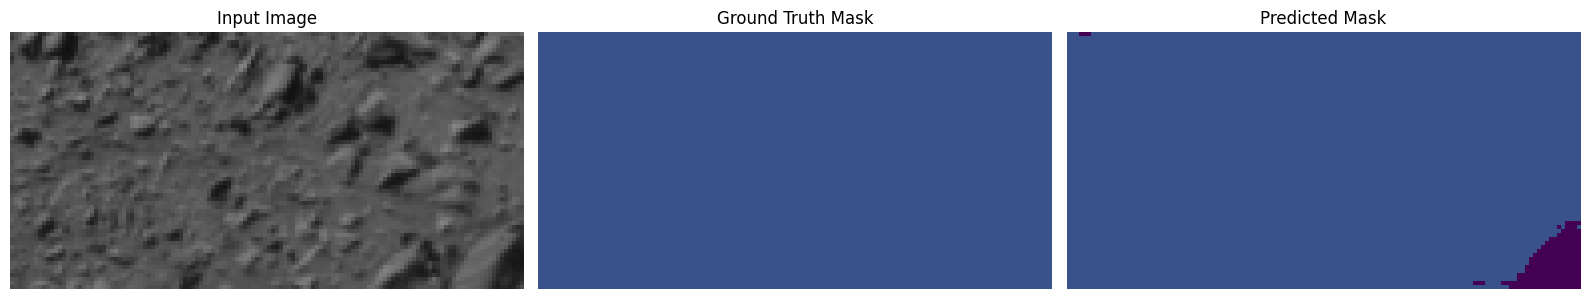

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8346 - loss: 0.0861 - mean_iou: 0.6793 - val_accuracy: 0.7873 - val_loss: 0.1102 - val_mean_iou: 0.5557 - learning_rate: 3.7325e-04
Epoch 62/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.8299 - loss: 0.0873 - mean_iou: 0.6565 - val_accuracy: 0.7752 - val_loss: 0.1187 - val_mean_iou: 0.5148 - learning_rate: 3.7325e-04
Epoch 63/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.8376 - loss: 0.0851 - mean_iou: 0.6823 - val_accuracy: 0.7587 - val_loss: 0.1257 - val_mean_iou: 0.5257 - learning_rate: 3.7325e-04
Epoch 64/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8415 - loss: 0.0835 - mean_iou: 0.6890 - val_accuracy: 0.7869 - val_loss: 0.1122 - val_mean_iou: 0.5217 - learning_rate: 3.7325e-04
Epoch 65/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8416 - loss: 0.0849 - mean_iou: 0.6804 - val_accuracy: 0.7809 - val_loss: 0.1168 - val_mean_iou: 0.5861 - learning_rate: 3.7325e-04
Epoch 66/1

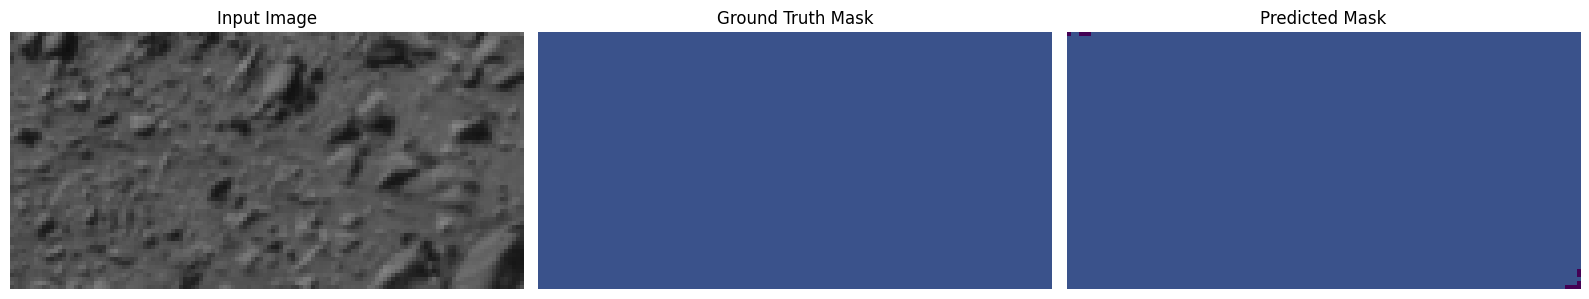

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8421 - loss: 0.0844 - mean_iou: 0.6979 - val_accuracy: 0.7742 - val_loss: 0.1216 - val_mean_iou: 0.5258 - learning_rate: 3.7325e-04
Epoch 67/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8463 - loss: 0.0833 - mean_iou: 0.6930 - val_accuracy: 0.7809 - val_loss: 0.1193 - val_mean_iou: 0.5348 - learning_rate: 2.6874e-04
Epoch 68/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8535 - loss: 0.0817 - mean_iou: 0.6914 - val_accuracy: 0.7832 - val_loss: 0.1183 - val_mean_iou: 0.5675 - learning_rate: 2.6874e-04
Epoch 69/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.8515 - loss: 0.0828 - mean_iou: 0.6957 - val_accuracy: 0.7890 - val_loss: 0.1139 - val_mean_iou: 0.5241 - learning_rate: 2.6874e-04
Epoch 70/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.8520 - loss: 0.0814 - mean_iou: 0.7009 - val_accuracy: 0.7718 - val_loss: 0.1271 - val_mean_iou: 0.5102 - learning_rate: 2.6874e-04
Epoch 71/

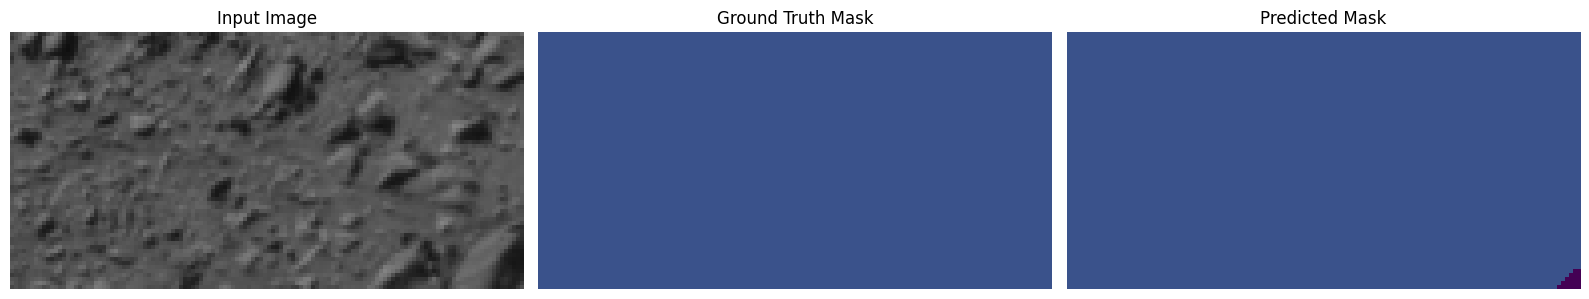

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8491 - loss: 0.0826 - mean_iou: 0.6959 - val_accuracy: 0.7851 - val_loss: 0.1162 - val_mean_iou: 0.5628 - learning_rate: 2.6874e-04
Epoch 72/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8560 - loss: 0.0809 - mean_iou: 0.7060 - val_accuracy: 0.7782 - val_loss: 0.1248 - val_mean_iou: 0.5265 - learning_rate: 2.6874e-04
Epoch 73/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8540 - loss: 0.0814 - mean_iou: 0.6862 - val_accuracy: 0.7816 - val_loss: 0.1233 - val_mean_iou: 0.5303 - learning_rate: 2.6874e-04
Epoch 74/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.8639 - loss: 0.0795 - mean_iou: 0.7007 - val_accuracy: 0.7865 - val_loss: 0.1226 - val_mean_iou: 0.5405 - learning_rate: 2.6874e-04
Epoch 75/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8619 - loss: 0.0801 - mean_iou: 0.7121 - val_accuracy: 0.7805 - val_loss: 0.1242 - val_mean_iou: 0.5409 - learning_rate: 1.9349e-04
Epoch 76/

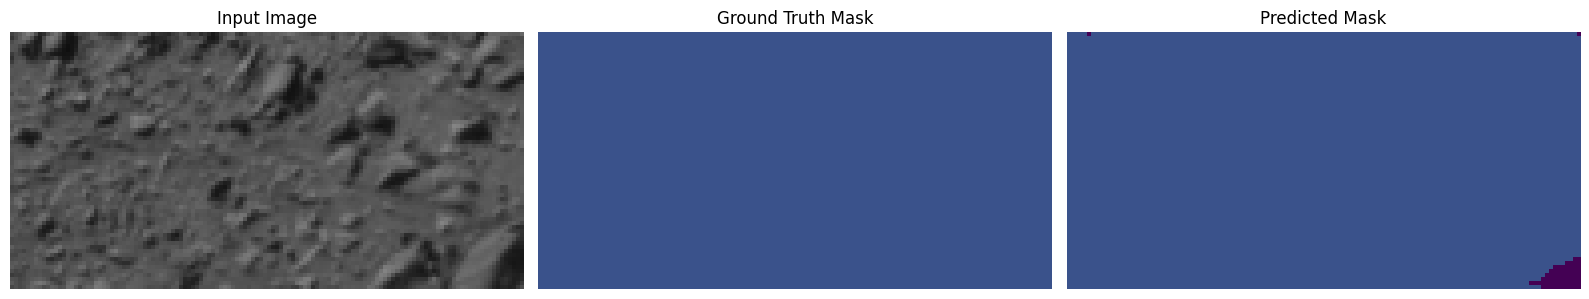

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.8657 - loss: 0.0797 - mean_iou: 0.6966 - val_accuracy: 0.7749 - val_loss: 0.1313 - val_mean_iou: 0.5498 - learning_rate: 1.9349e-04
Epoch 77/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8593 - loss: 0.0812 - mean_iou: 0.7035 - val_accuracy: 0.7907 - val_loss: 0.1203 - val_mean_iou: 0.5363 - learning_rate: 1.9349e-04
Epoch 78/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8645 - loss: 0.0796 - mean_iou: 0.6968 - val_accuracy: 0.7912 - val_loss: 0.1155 - val_mean_iou: 0.5808 - learning_rate: 1.9349e-04
Epoch 79/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8677 - loss: 0.0791 - mean_iou: 0.7132 - val_accuracy: 0.7983 - val_loss: 0.1144 - val_mean_iou: 0.5770 - learning_rate: 1.9349e-04
Epoch 80/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8698 - loss: 0.0782 - mean_iou: 0.7164 - val_accuracy: 0.7865 - val_loss: 0.1173 - val_mean_iou: 0.5473 - learning_rate: 1.9349e-04
Epoch 81/

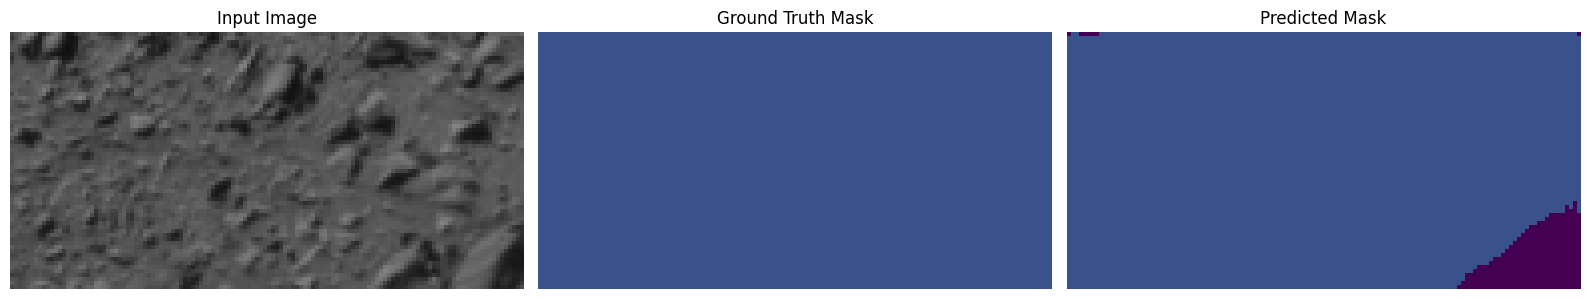

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8697 - loss: 0.0784 - mean_iou: 0.7163 - val_accuracy: 0.7918 - val_loss: 0.1190 - val_mean_iou: 0.5570 - learning_rate: 1.9349e-04
Epoch 82/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8663 - loss: 0.0794 - mean_iou: 0.7081 - val_accuracy: 0.7902 - val_loss: 0.1167 - val_mean_iou: 0.5993 - learning_rate: 1.9349e-04
Epoch 83/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8689 - loss: 0.0785 - mean_iou: 0.7187 - val_accuracy: 0.7873 - val_loss: 0.1173 - val_mean_iou: 0.5855 - learning_rate: 1.3931e-04
Epoch 84/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8718 - loss: 0.0775 - mean_iou: 0.7175 - val_accuracy: 0.7916 - val_loss: 0.1170 - val_mean_iou: 0.6011 - learning_rate: 1.3931e-04
Epoch 85/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8718 - loss: 0.0780 - mean_iou: 0.7205 - val_accuracy: 0.7834 - val_loss: 0.1254 - val_mean_iou: 0.5725 - learning_rate: 1.3931e-04
Epoch 86/1

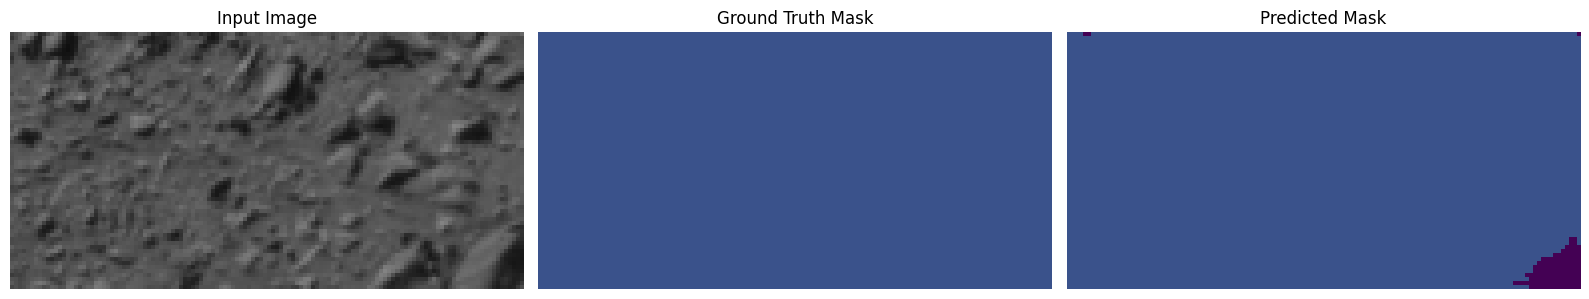

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8732 - loss: 0.0780 - mean_iou: 0.7166 - val_accuracy: 0.7892 - val_loss: 0.1211 - val_mean_iou: 0.5755 - learning_rate: 1.3931e-04
Epoch 87/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8790 - loss: 0.0771 - mean_iou: 0.7279 - val_accuracy: 0.7801 - val_loss: 0.1273 - val_mean_iou: 0.5636 - learning_rate: 1.3931e-04
Epoch 88/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8734 - loss: 0.0785 - mean_iou: 0.7114 - val_accuracy: 0.7917 - val_loss: 0.1188 - val_mean_iou: 0.6060 - learning_rate: 1.3931e-04
Epoch 89/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8811 - loss: 0.0768 - mean_iou: 0.7336 - val_accuracy: 0.7912 - val_loss: 0.1165 - val_mean_iou: 0.5838 - learning_rate: 1.3931e-04
Epoch 90/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8805 - loss: 0.0768 - mean_iou: 0.7272 - val_accuracy: 0.7971 - val_loss: 0.1149 - val_mean_iou: 0.5864 - learning_rate: 1.3931e-04
Epoch 91/

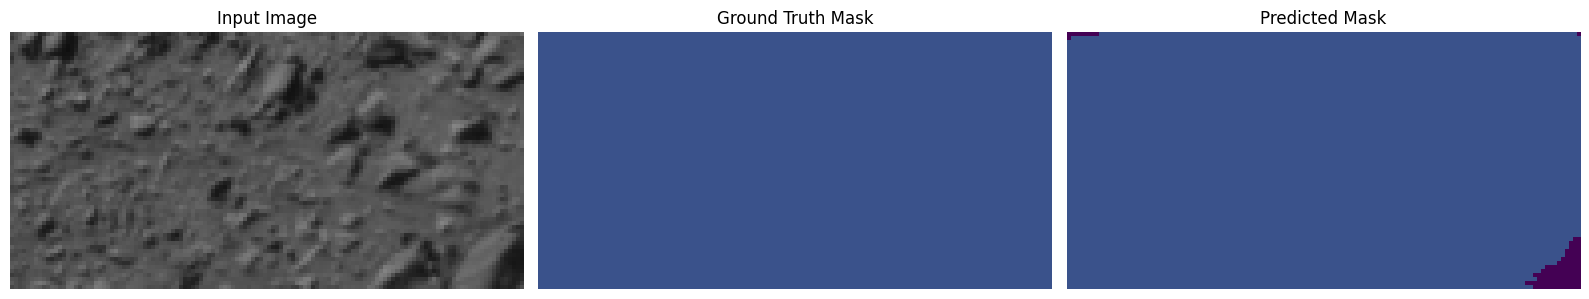

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8805 - loss: 0.0770 - mean_iou: 0.7243 - val_accuracy: 0.7953 - val_loss: 0.1145 - val_mean_iou: 0.5954 - learning_rate: 1.0031e-04
Epoch 92/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8787 - loss: 0.0768 - mean_iou: 0.7324 - val_accuracy: 0.7961 - val_loss: 0.1152 - val_mean_iou: 0.6023 - learning_rate: 1.0031e-04
Epoch 93/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8832 - loss: 0.0762 - mean_iou: 0.7350 - val_accuracy: 0.7916 - val_loss: 0.1183 - val_mean_iou: 0.5818 - learning_rate: 1.0031e-04
Epoch 94/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.8788 - loss: 0.0770 - mean_iou: 0.7264 - val_accuracy: 0.7970 - val_loss: 0.1163 - val_mean_iou: 0.6003 - learning_rate: 1.0031e-04
Epoch 95/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8819 - loss: 0.0763 - mean_iou: 0.7280 - val_accuracy: 0.7951 - val_loss: 0.1180 - val_mean_iou: 0.6106 - learning_rate: 1.0031e-04
Epoch 96/

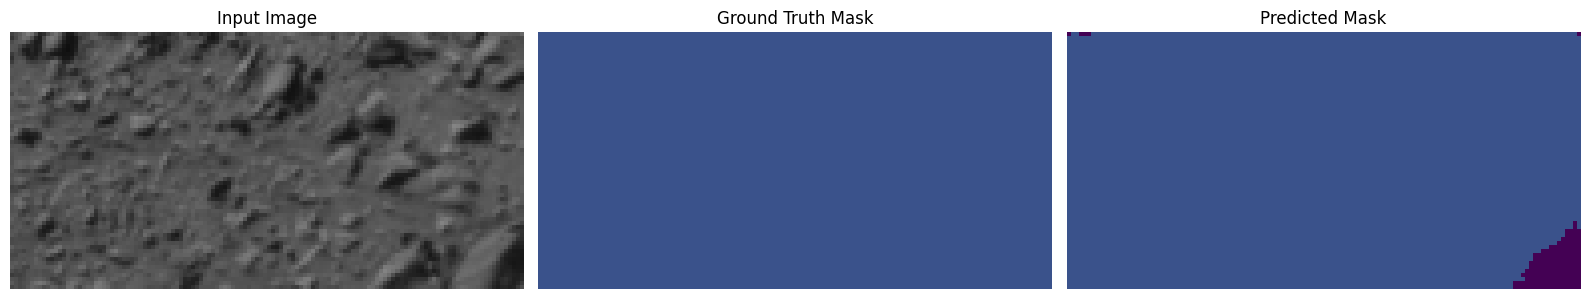

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8865 - loss: 0.0755 - mean_iou: 0.7308 - val_accuracy: 0.7909 - val_loss: 0.1199 - val_mean_iou: 0.5990 - learning_rate: 1.0031e-04
Epoch 97/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8831 - loss: 0.0763 - mean_iou: 0.7308 - val_accuracy: 0.7913 - val_loss: 0.1210 - val_mean_iou: 0.6066 - learning_rate: 1.0031e-04
Epoch 98/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8876 - loss: 0.0753 - mean_iou: 0.7307 - val_accuracy: 0.7920 - val_loss: 0.1191 - val_mean_iou: 0.6011 - learning_rate: 1.0031e-04
Epoch 99/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8859 - loss: 0.0759 - mean_iou: 0.7340 - val_accuracy: 0.7944 - val_loss: 0.1206 - val_mean_iou: 0.6042 - learning_rate: 7.2220e-05
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7676 - loss: 0.2059 - mean_iou: 0.4961   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:               loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.20),  # Utilizza la loss combinata,

  return {key: serialize_keras_object(value) for key, value in obj.items()}


37/37 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.7694 - loss: 0.2048 - mean_iou: 0.4982 - val_accuracy: 0.5384 - val_loss: 0.2703 - val_mean_iou: 0.3140 - learning_rate: 0.0010
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 72s 806ms/step - accuracy: 0.8507 - loss: 0.1411 - mean_iou: 0.6779 - val_accuracy: 0.7166 - val_loss: 0.2041 - val_mean_iou: 0.3816 - learning_rate: 0.0010
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 763ms/step - accuracy: 0.8734 - loss: 0.1346 - mean_iou: 0.7041 - val_accuracy: 0.3875 - val_loss: 0.2160 - val_mean_iou: 0.1664 - learning_rate: 0.0010
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 770ms/step - accuracy: 0.8724 - loss: 0.1357 - mean_iou: 0.7064 - val_accuracy: 0.6366 - val_loss: 0.2126 - val_mean_iou: 0.3042 - learning_rate: 0.0010
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 798ms/step - accuracy: 0.8778 - loss: 0.1318 - mean_iou: 0.7115 - val_accuracy: 0.6192 - val_loss: 0.2227 - val_mean_iou: 0.2824 - learning_rate: 0.0010
Epoch 6/1000
37/37 ━━━━━━━━━━━

In [ ]:
# prompt: Train the models

# Training of the first model
history1 = unet1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint1, viz_callback],
    #class_weight=class_weights_dict
)

# Load the best weights for unet1'''
unet1.load_weights('UNET1.keras')


# Create a new dataset for the second U-Net, including the predictions of the first one
def make_dataset_unet2(X, y, unet1, batch_size=32, shuffle=False):
    # Generate predictions with the first U-Net
    predictions = unet1.predict(X, batch_size=batch_size, verbose=1)
    # Combine images and predictions for input to second U-Net
    combined_data = np.concatenate((X, predictions), axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices((combined_data, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset_2 = make_dataset_unet2(X_train, y_train, unet1, batch_size=BATCH_SIZE, shuffle=True)
val_dataset_2 = make_dataset_unet2(X_val, y_val, unet1, batch_size=BATCH_SIZE)

# Training of the second model
history2 = unet2.fit(
    train_dataset_2,
    validation_data=val_dataset_2,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint2],
    #class_weight=class_weights_dict
)

unet1.save('unet1_model.keras')
unet2.save('unet2_model.keras')
print("Final model saved successfully!")

del unet1
del unet2

## LORIS

In [ ]:
def focal_loss_segmentation(gamma=2.0, alpha=[0.2, 0.2, 0.2, 0.2, 0.30]):
    def loss_function(y_true, y_pred):
        # Converti y_true in one-hot encoding
        num_classes = y_pred.shape[-1]
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

        # Rimuovi la dimensione superflua da y_true_one_hot
        y_true_one_hot = tf.squeeze(y_true_one_hot, axis=-2)  # Rimuove l'asse con dimensione 1

        # Clip di y_pred per evitare log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Pesatura delle classi con alpha
        alpha_tensor = tf.constant(alpha, dtype=tf.float32)
        alpha_weights = tf.reduce_sum(alpha_tensor * y_true_one_hot, axis=-1, keepdims=True)  # Aggiungi una dimensione

        # Calcola cross-entropy e pesi focali
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        weights = alpha_weights * tf.math.pow(1 - y_pred, gamma)
        focal_loss = weights * cross_entropy

        # Media sui pixel e batch
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss_function


def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Calculates the Dice loss between the predicted and true segmentation masks.

    Args:
        y_true: True segmentation mask.
        y_pred: Predicted segmentation mask.
        smooth: Smoothing factor to avoid division by zero.

    Returns:
        The Dice loss.
    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

In [ ]:
def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss_segmentation()(y_true, y_pred)
    return 0.5 * dice + 0.5 * focal

In [ ]:
# prompt: Calcola i pesi delle classi

def calculate_class_weights(y_train):
    """
    Calculates class weights for imbalanced datasets.

    Args:
        y_train: A NumPy array representing the ground truth labels.

    Returns:
        A dictionary containing class weights.
    """

    # Flatten the y_train array
    y_train_flat = y_train.flatten()

    # Count occurrences of each class
    class_counts = np.bincount(y_train_flat)

    # Calculate class weights
    class_weights = 1.0 / class_counts

    # Normalize class weights
    class_weights = class_weights / np.sum(class_weights)

    # Create a dictionary for class weights
    class_weights_dict = dict(enumerate(class_weights))
    return class_weights_dict

# Example Usage
# Assuming you have your training labels in y_train (NumPy array)
class_weights_dict = calculate_class_weights(y_train)
print(class_weights_dict)

{0: 0.005709214898111396, 1: 0.004105392742947162, 2: 0.005854530065569897, 3: 0.007755073897583088, 4: 0.9765757883957885}


In [ ]:
def custom_normalization(x, level):
    if level == 'shallow':
        return tfkl.BatchNormalization()(x)
    elif level == 'middle':
        return tfkl.LayerNormalization()(x)
    elif level == 'deep':
        groups = 8  # Scegli il numero di gruppi
        return tfkl.GroupNormalization(groups=groups)(x)


In [ ]:
# prompt: Voglio una funzione che ritorni una rete unet con queste caratteristiche. Residual_block, bottleneck con squeeze-and-excitation, perdite ai livelli intermedi della rete per incoraggiare l'apprendimento in ogni fase con pesi, diverse tecniche di normalizzazione a seconda della profondità (la funzione)

from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model

def residual_block(input_tensor, filters, kernel_size=3, activation='LeakyReLU', normalization_level='shallow', name=''):
    x = input_tensor
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name + '_conv1')(x)
    x = custom_normalization(x, normalization_level)
    #x = tfkl.Activation(activation, name=name + '_activation1')(x)
    x = tfkl.LeakyReLU(name = name + '_activation1')(x)
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name + '_conv2')(x)
    x = custom_normalization(x, normalization_level)

    # Squeeze-and-excitation block
    se = tfkl.GlobalAveragePooling2D()(x)
    se = tfkl.Dense(filters // 16, activation='relu')(se)
    se = tfkl.Dense(filters, activation='sigmoid')(se)
    se = tfkl.Reshape((1, 1, filters))(se)
    x = tfkl.Multiply()([x, se])

    skip = tfkl.Conv2D(filters, kernel_size=(1, 1), padding='same', name=name + '_skip_conv')(input_tensor)


    x = tfkl.Add()([x, skip])
    x = tfkl.LeakyReLU()(x)
    return x


def create_unet_model_with_residuals(input_shape, num_classes, num_layers=4, start_filters=64):
    inputs = tfkl.Input(shape=input_shape)

    # Encoder
    skips = []
    x = inputs
    for i in range(num_layers):
        normalization_level = 'shallow' if i < num_layers // 2 else ('middle' if i == num_layers // 2 else 'deep')
        x = residual_block(x, start_filters * (2**i), normalization_level=normalization_level, name=f'encoder_block_{i}')
        skips.append(x)
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'maxpool_{i}_')(x)

    # Bottleneck
    x = residual_block(x, start_filters * (2**num_layers), normalization_level='deep', name=f'bottleneck')

    # Decoder
    for i in range(num_layers - 1, -1, -1):
        normalization_level = 'deep' if i < num_layers // 2 else ('middle' if i == num_layers // 2 else 'shallow')
        x = tfkl.Conv2DTranspose(start_filters * (2**i), kernel_size=(2, 2), strides=(2, 2), padding='same', name=f'upsample_{i}_')(x)
        x = tfkl.Concatenate(axis=-1, name=f'concat_{i}_')([x, skips[i]])
        x = residual_block(x, start_filters * (2**i), normalization_level=normalization_level, name=f'decoder_block_{i}')

    # Output
    outputs = tfkl.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='unet_model_with_residuals')
    return model

In [ ]:
superUnet = create_unet_model_with_residuals(input_shape, NUM_CLASSES, num_layers=4, start_filters=64)

superUnet.compile(
    optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[4], y_val[4])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.72,
                              patience=8)

checkpoint1 = ModelCheckpoint('superUNET.keras',
                             monitor='val_accuracy',  # Monitora la validazione accuracy
                             save_best_only=True,     # Salva solo il miglior modello
                             mode='max',              # Il miglior modello è quello con la max accuracy
                             verbose=0)               # Mostra un messaggio ogni volta che viene salvato il modello


superUnet.summary()

Model: "unet_model_with_residuals"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 64, 128, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_conv1     │ (None, 64, 128, 64)    │          1,792 │ input_layer_6[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 64, 128, 64)    │            256 │ encoder_block_0_conv1… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_activati… │ (None, 64, 128, 64)    │              0 │ batch_normalization_7… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_conv2     │ (None, 64, 128, 64)    │         36,928 │ encoder_block_0_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 64, 128, 64)    │            256 │ encoder_block_0_conv2… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ batch_normalization_8… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │            320 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 1, 64)       │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 64, 128, 64)    │              0 │ batch_normalization_8… │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_0_skip_conv │ (None, 64, 128, 64)    │            256 │ input_layer_6[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 128, 64)    │              0 │ multiply_2[0][0],      │
│                           │                        │                │ encoder_block_0_skip_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 128, 64)    │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_0_ (MaxPoolin

 Total params: 32,663,613 (124.60 MB)

 Trainable params: 32,660,797 (124.59 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2824 - loss: 5.9543e-04 - mean_iou: 0.1255   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: combined_loss(y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


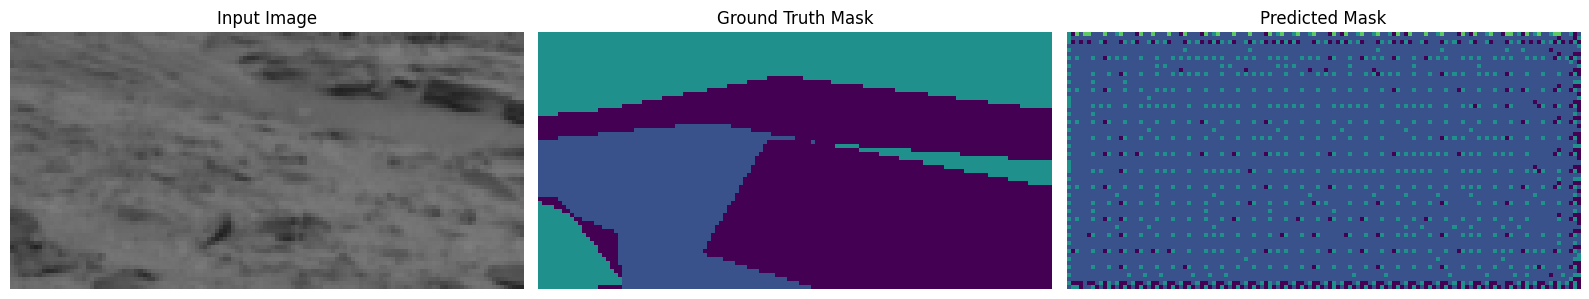

35/35 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.2844 - loss: 5.9138e-04 - mean_iou: 0.1265 - val_accuracy: 0.3296 - val_loss: 0.0637 - val_mean_iou: 0.1010 - learning_rate: 1.0000e-04
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 514ms/step - accuracy: 0.4564 - loss: 3.7044e-04 - mean_iou: 0.2155 - val_accuracy: 0.3069 - val_loss: 0.0755 - val_mean_iou: 0.1198 - learning_rate: 1.0000e-04
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step - accuracy: 0.5014 - loss: 3.6653e-04 - mean_iou: 0.2514 - val_accuracy: 0.2265 - val_loss: 0.0868 - val_mean_iou: 0.0643 - learning_rate: 1.0000e-04
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy: 0.5350 - loss: 2.8638e-04 - mean_iou: 0.2743 - val_accuracy: 0.2171 - val_loss: 0.1051 - val_mean_iou: 0.0572 - learning_rate: 1.0000e-04
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 502ms/step - accuracy: 0.5890 - loss: 2.7087e-04 - mean_iou: 0.3147 - val_accuracy: 0.2171 - val_loss: 0.1116 - val_mean_iou: 0.0715 - learning_rate: 1

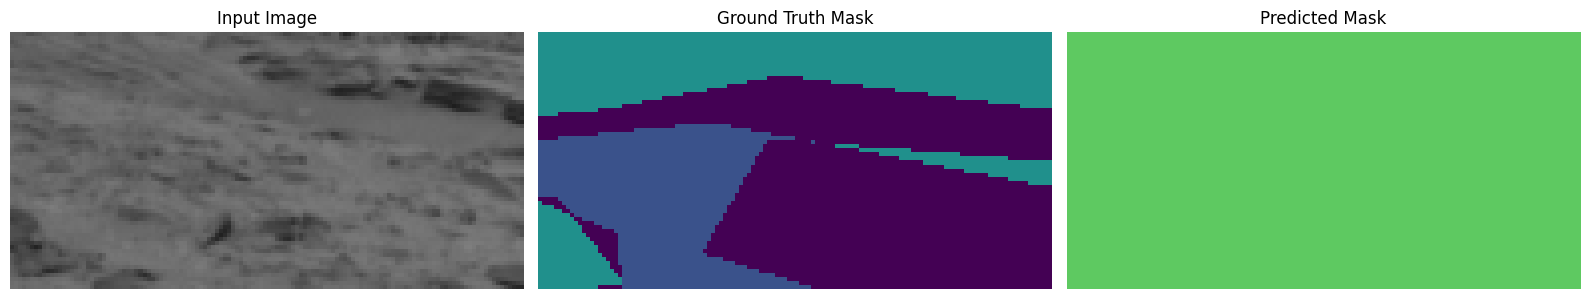

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 508ms/step - accuracy: 0.6357 - loss: 2.3549e-04 - mean_iou: 0.3524 - val_accuracy: 0.2171 - val_loss: 0.1105 - val_mean_iou: 0.0715 - learning_rate: 1.0000e-04
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.6563 - loss: 2.1611e-04 - mean_iou: 0.3715 - val_accuracy: 0.2171 - val_loss: 0.1231 - val_mean_iou: 0.0715 - learning_rate: 1.0000e-04
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 513ms/step - accuracy: 0.6482 - loss: 2.3411e-04 - mean_iou: 0.3566 - val_accuracy: 0.2171 - val_loss: 0.1436 - val_mean_iou: 0.0572 - learning_rate: 1.0000e-04
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.6643 - loss: 2.3203e-04 - mean_iou: 0.3696 - val_accuracy: 0.2171 - val_loss: 0.1429 - val_mean_iou: 0.0715 - learning_rate: 1.0000e-04
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy: 0.6560 - loss: 1.9887e-04 - mean_iou: 0.3734 - val_accuracy: 0.2171 - val_loss: 0.1413 - val_mean_iou: 0.0572 - learning_rate

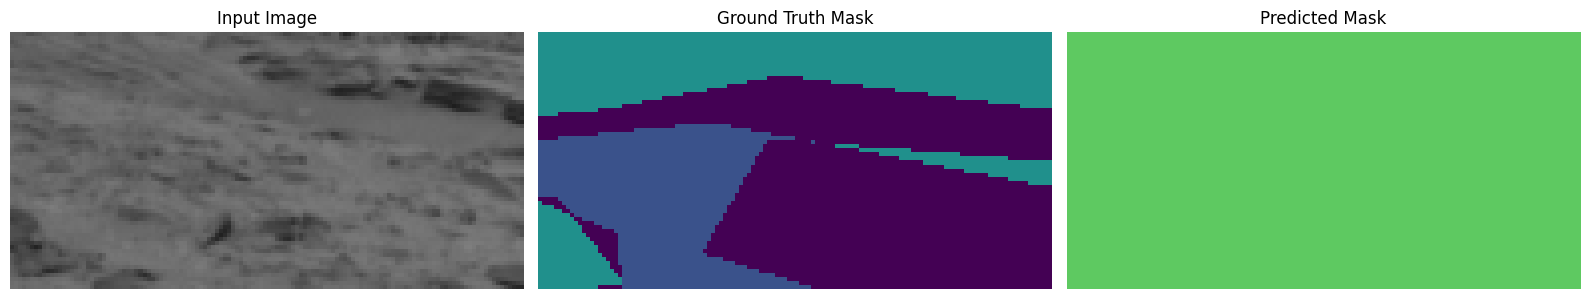

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 511ms/step - accuracy: 0.6829 - loss: 2.1262e-04 - mean_iou: 0.3853 - val_accuracy: 0.2183 - val_loss: 0.1483 - val_mean_iou: 0.0579 - learning_rate: 7.2000e-05
Epoch 12/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 501ms/step - accuracy: 0.6962 - loss: 1.9651e-04 - mean_iou: 0.4019 - val_accuracy: 0.2311 - val_loss: 0.1387 - val_mean_iou: 0.0656 - learning_rate: 7.2000e-05
Epoch 13/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - accuracy: 0.6884 - loss: 2.1787e-04 - mean_iou: 0.3935 - val_accuracy: 0.2943 - val_loss: 0.1271 - val_mean_iou: 0.1078 - learning_rate: 7.2000e-05
Epoch 14/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.6999 - loss: 2.0484e-04 - mean_iou: 0.4056 - val_accuracy: 0.3028 - val_loss: 0.1163 - val_mean_iou: 0.1123 - learning_rate: 7.2000e-05
Epoch 15/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 620ms/step - accuracy: 0.6982 - loss: 1.7867e-04 - mean_iou: 0.4039 - val_accuracy: 0.4269 - val_loss: 0.0655 - val_mean_iou: 0.2091 - learning_r

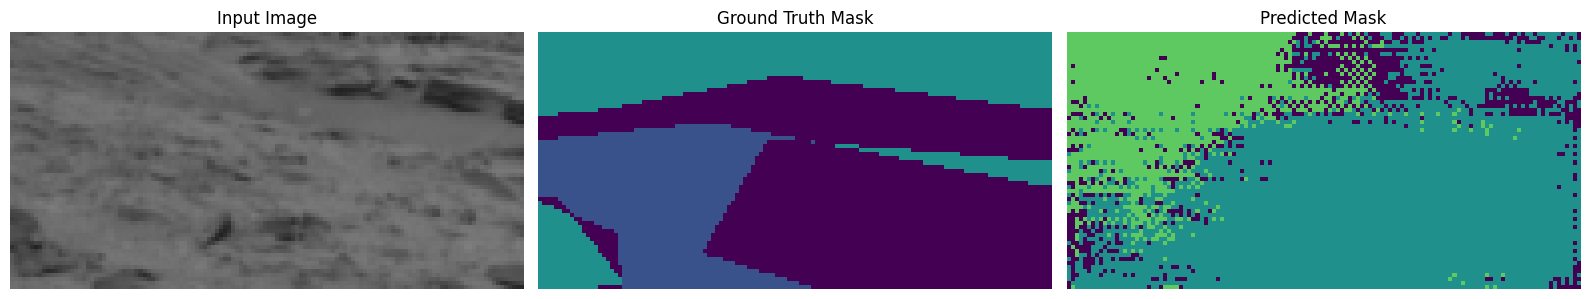

35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 679ms/step - accuracy: 0.6891 - loss: 1.7433e-04 - mean_iou: 0.3944 - val_accuracy: 0.4550 - val_loss: 0.0510 - val_mean_iou: 0.2162 - learning_rate: 7.2000e-05
Epoch 17/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - accuracy: 0.7078 - loss: 1.7018e-04 - mean_iou: 0.4083 - val_accuracy: 0.5013 - val_loss: 0.0433 - val_mean_iou: 0.2462 - learning_rate: 7.2000e-05
Epoch 18/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 728ms/step - accuracy: 0.7052 - loss: 1.7684e-04 - mean_iou: 0.4043 - val_accuracy: 0.6332 - val_loss: 0.0251 - val_mean_iou: 0.3464 - learning_rate: 7.2000e-05
Epoch 19/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 853ms/step - accuracy: 0.7090 - loss: 1.7510e-04 - mean_iou: 0.4087 - val_accuracy: 0.6483 - val_loss: 0.0246 - val_mean_iou: 0.3570 - learning_rate: 7.2000e-05
Epoch 20/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 518ms/step - accuracy: 0.7182 - loss: 1.6596e-04 - mean_iou: 0.4186 - val_accuracy: 0.5654 - val_loss: 0.0442 - val_mean_iou: 0.2768 - learning_r

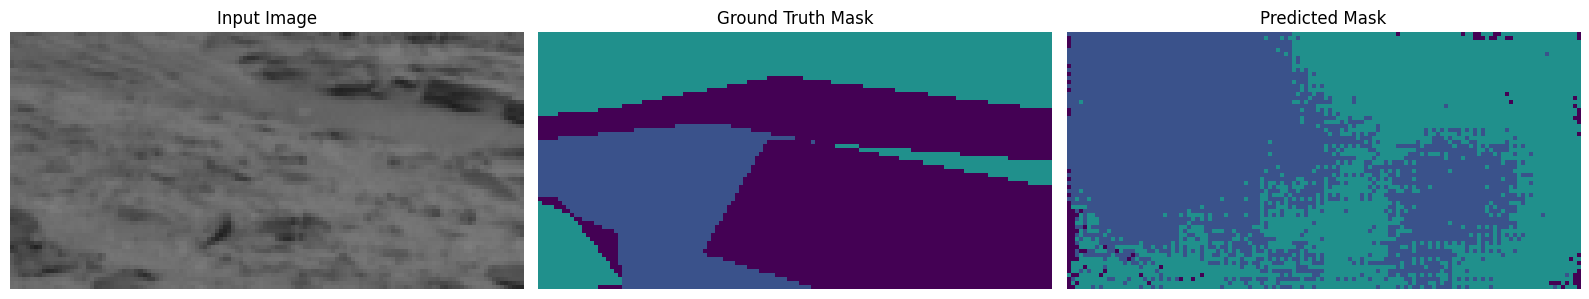

35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 782ms/step - accuracy: 0.7143 - loss: 1.7657e-04 - mean_iou: 0.4176 - val_accuracy: 0.6708 - val_loss: 0.0237 - val_mean_iou: 0.3632 - learning_rate: 7.2000e-05
Epoch 22/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.7203 - loss: 1.5822e-04 - mean_iou: 0.4187 - val_accuracy: 0.6703 - val_loss: 0.0214 - val_mean_iou: 0.3681 - learning_rate: 7.2000e-05
Epoch 23/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 508ms/step - accuracy: 0.7278 - loss: 1.4860e-04 - mean_iou: 0.4264 - val_accuracy: 0.6624 - val_loss: 0.0210 - val_mean_iou: 0.3765 - learning_rate: 7.2000e-05
Epoch 24/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.7262 - loss: 1.6347e-04 - mean_iou: 0.4323 - val_accuracy: 0.6172 - val_loss: 0.0318 - val_mean_iou: 0.3245 - learning_rate: 7.2000e-05
Epoch 25/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.7256 - loss: 1.3206e-04 - mean_iou: 0.4288 - val_accuracy: 0.6465 - val_loss: 0.0303 - val_mean_iou: 0.3390 - learning_r

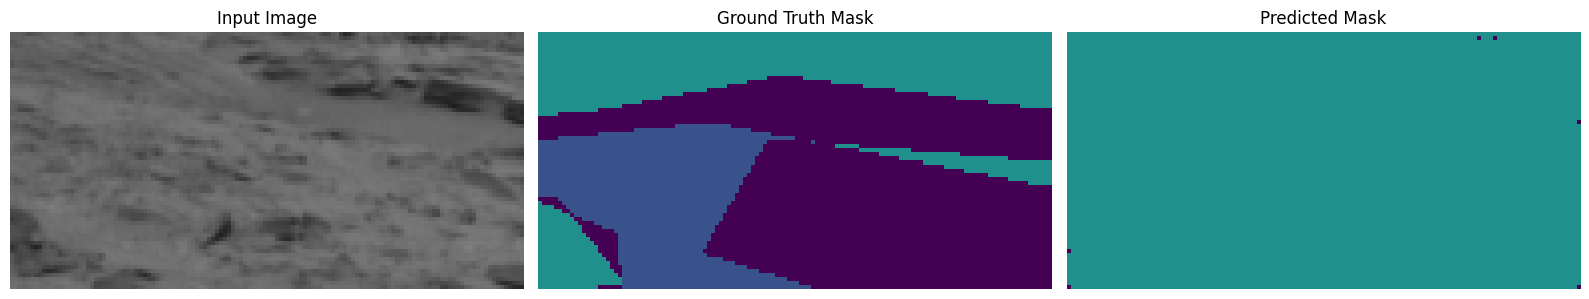

35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 670ms/step - accuracy: 0.7356 - loss: 1.5112e-04 - mean_iou: 0.4409 - val_accuracy: 0.7012 - val_loss: 0.0176 - val_mean_iou: 0.3971 - learning_rate: 7.2000e-05
Epoch 27/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 506ms/step - accuracy: 0.7416 - loss: 1.5747e-04 - mean_iou: 0.4462 - val_accuracy: 0.6998 - val_loss: 0.0171 - val_mean_iou: 0.4001 - learning_rate: 7.2000e-05
Epoch 28/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 661ms/step - accuracy: 0.7376 - loss: 1.4378e-04 - mean_iou: 0.4390 - val_accuracy: 0.7108 - val_loss: 0.0162 - val_mean_iou: 0.3952 - learning_rate: 7.2000e-05
Epoch 29/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 773ms/step - accuracy: 0.7356 - loss: 1.5962e-04 - mean_iou: 0.4309 - val_accuracy: 0.7136 - val_loss: 0.0159 - val_mean_iou: 0.4123 - learning_rate: 7.2000e-05
Epoch 30/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 513ms/step - accuracy: 0.7422 - loss: 1.4521e-04 - mean_iou: 0.4475 - val_accuracy: 0.6204 - val_loss: 0.0297 - val_mean_iou: 0.3284 - learning_r

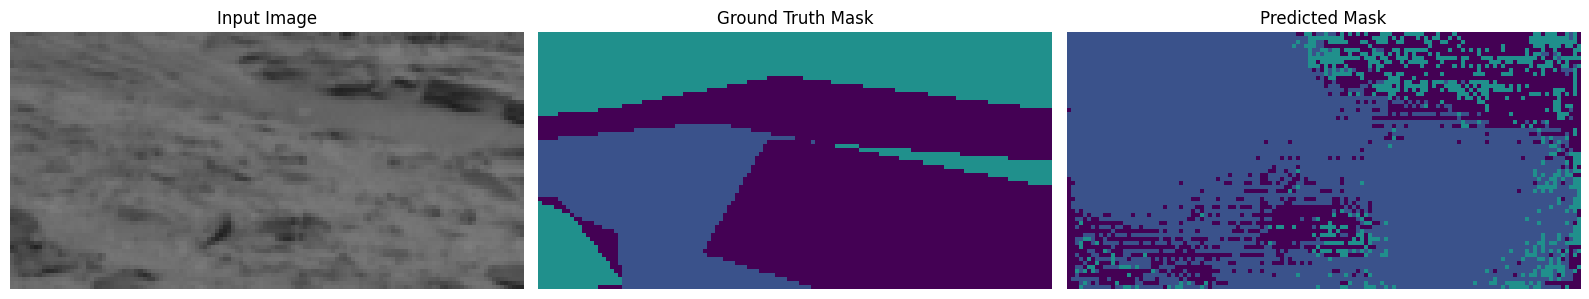

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 514ms/step - accuracy: 0.7340 - loss: 1.4341e-04 - mean_iou: 0.4394 - val_accuracy: 0.6428 - val_loss: 0.0218 - val_mean_iou: 0.3384 - learning_rate: 7.2000e-05
Epoch 32/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 745ms/step - accuracy: 0.7355 - loss: 1.5687e-04 - mean_iou: 0.4434 - val_accuracy: 0.7350 - val_loss: 0.0116 - val_mean_iou: 0.4270 - learning_rate: 7.2000e-05
Epoch 33/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - accuracy: 0.7389 - loss: 1.5541e-04 - mean_iou: 0.4463 - val_accuracy: 0.7118 - val_loss: 0.0153 - val_mean_iou: 0.4002 - learning_rate: 7.2000e-05
Epoch 34/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - accuracy: 0.7456 - loss: 1.1808e-04 - mean_iou: 0.4538 - val_accuracy: 0.6444 - val_loss: 0.0210 - val_mean_iou: 0.3082 - learning_rate: 7.2000e-05
Epoch 35/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 515ms/step - accuracy: 0.7453 - loss: 1.0597e-04 - mean_iou: 0.4531 - val_accuracy: 0.7317 - val_loss: 0.0123 - val_mean_iou: 0.4329 - learning_r

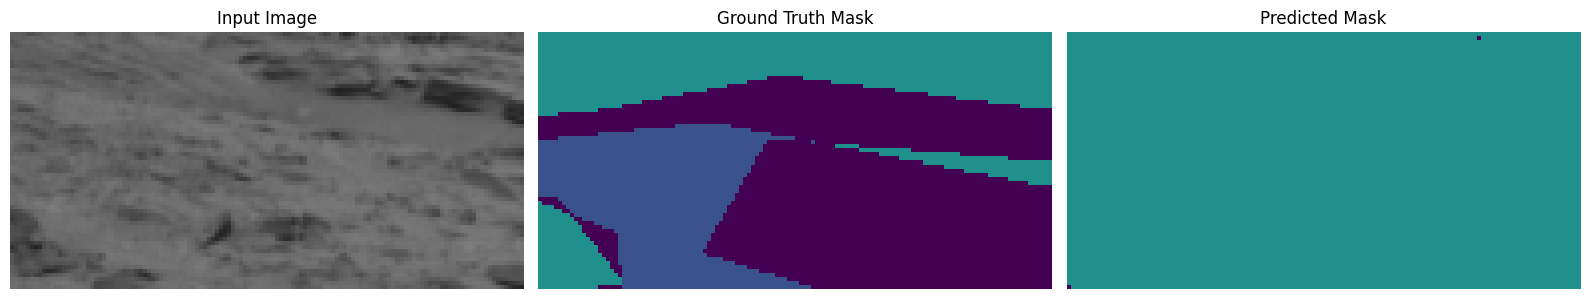

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 513ms/step - accuracy: 0.7560 - loss: 9.3096e-05 - mean_iou: 0.4643 - val_accuracy: 0.6714 - val_loss: 0.0213 - val_mean_iou: 0.3756 - learning_rate: 7.2000e-05
Epoch 37/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 961ms/step - accuracy: 0.7490 - loss: 1.3460e-04 - mean_iou: 0.4586 - val_accuracy: 0.7400 - val_loss: 0.0118 - val_mean_iou: 0.4331 - learning_rate: 7.2000e-05
Epoch 38/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.7397 - loss: 1.3913e-04 - mean_iou: 0.4558 - val_accuracy: 0.7339 - val_loss: 0.0136 - val_mean_iou: 0.4330 - learning_rate: 7.2000e-05
Epoch 39/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 506ms/step - accuracy: 0.7559 - loss: 1.5072e-04 - mean_iou: 0.4667 - val_accuracy: 0.7174 - val_loss: 0.0180 - val_mean_iou: 0.4201 - learning_rate: 7.2000e-05
Epoch 40/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 516ms/step - accuracy: 0.7388 - loss: 1.0715e-04 - mean_iou: 0.4470 - val_accuracy: 0.7152 - val_loss: 0.0163 - val_mean_iou: 0.4121 - learning_r

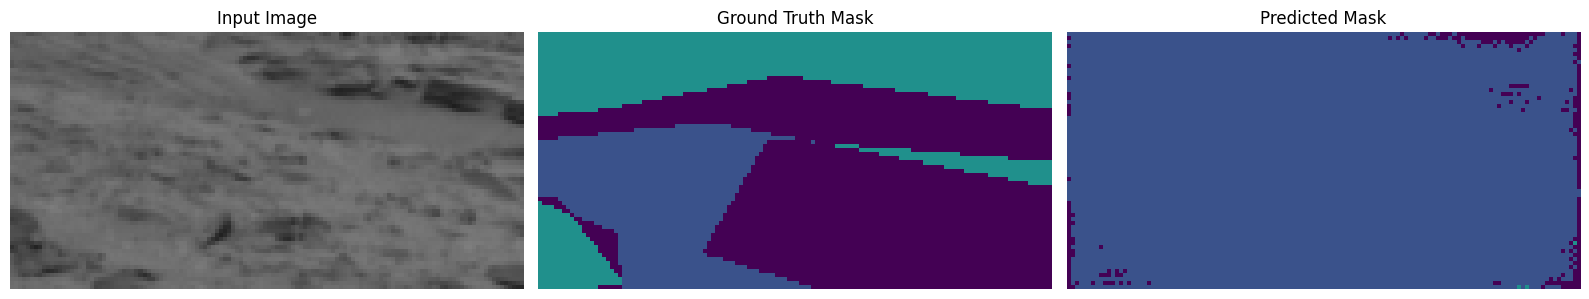

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.7592 - loss: 9.5444e-05 - mean_iou: 0.4692 - val_accuracy: 0.7049 - val_loss: 0.0192 - val_mean_iou: 0.3951 - learning_rate: 5.1840e-05
Epoch 42/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.7743 - loss: 1.0782e-04 - mean_iou: 0.4857 - val_accuracy: 0.6538 - val_loss: 0.0381 - val_mean_iou: 0.3266 - learning_rate: 5.1840e-05
Epoch 43/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 821ms/step - accuracy: 0.7779 - loss: 9.5563e-05 - mean_iou: 0.4909 - val_accuracy: 0.7467 - val_loss: 0.0134 - val_mean_iou: 0.4569 - learning_rate: 5.1840e-05
Epoch 44/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 506ms/step - accuracy: 0.7813 - loss: 9.1630e-05 - mean_iou: 0.4926 - val_accuracy: 0.7380 - val_loss: 0.0120 - val_mean_iou: 0.4436 - learning_rate: 5.1840e-05
Epoch 45/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - accuracy: 0.7741 - loss: 1.1076e-04 - mean_iou: 0.4857 - val_accuracy: 0.7420 - val_loss: 0.0113 - val_mean_iou: 0.4335 - learning_r

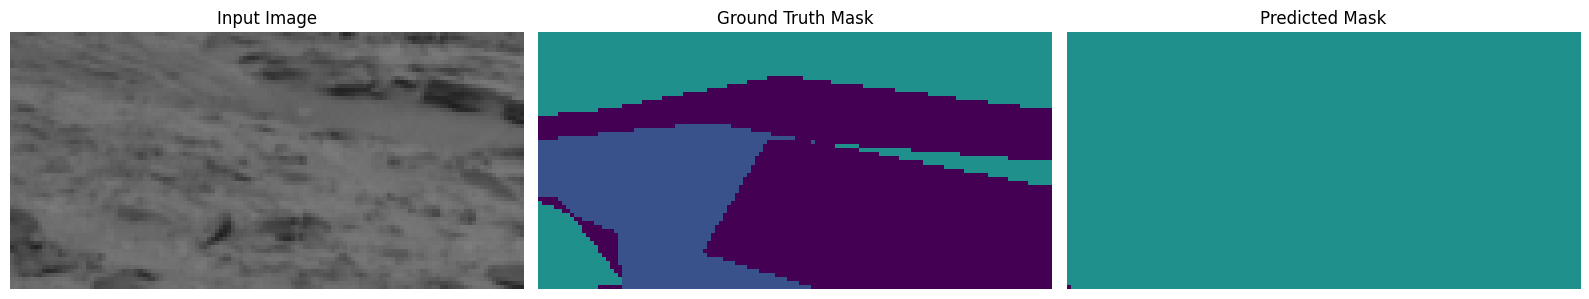

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 519ms/step - accuracy: 0.7875 - loss: 9.0799e-05 - mean_iou: 0.4997 - val_accuracy: 0.6635 - val_loss: 0.0231 - val_mean_iou: 0.3776 - learning_rate: 5.1840e-05
Epoch 47/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.7880 - loss: 7.3444e-05 - mean_iou: 0.4971 - val_accuracy: 0.7293 - val_loss: 0.0179 - val_mean_iou: 0.4205 - learning_rate: 5.1840e-05
Epoch 48/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 501ms/step - accuracy: 0.7863 - loss: 1.0705e-04 - mean_iou: 0.5051 - val_accuracy: 0.7309 - val_loss: 0.0162 - val_mean_iou: 0.4233 - learning_rate: 5.1840e-05
Epoch 49/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - accuracy: 0.7902 - loss: 8.3038e-05 - mean_iou: 0.5173 - val_accuracy: 0.7384 - val_loss: 0.0158 - val_mean_iou: 0.4270 - learning_rate: 5.1840e-05
Epoch 50/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 727ms/step - accuracy: 0.7892 - loss: 9.1121e-05 - mean_iou: 0.5014 - val_accuracy: 0.7544 - val_loss: 0.0098 - val_mean_iou: 0.4632 - learning_r

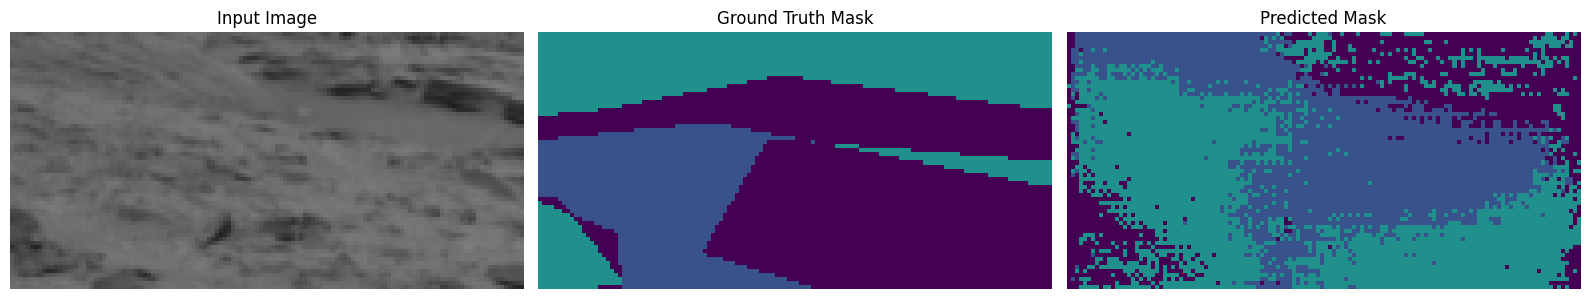

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 514ms/step - accuracy: 0.7982 - loss: 7.5450e-05 - mean_iou: 0.5216 - val_accuracy: 0.7292 - val_loss: 0.0188 - val_mean_iou: 0.4192 - learning_rate: 5.1840e-05
Epoch 52/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step - accuracy: 0.7858 - loss: 1.0377e-04 - mean_iou: 0.4998 - val_accuracy: 0.7403 - val_loss: 0.0150 - val_mean_iou: 0.4423 - learning_rate: 5.1840e-05
Epoch 53/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.8030 - loss: 1.0482e-04 - mean_iou: 0.5384 - val_accuracy: 0.7236 - val_loss: 0.0148 - val_mean_iou: 0.4124 - learning_rate: 5.1840e-05
Epoch 54/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 502ms/step - accuracy: 0.7820 - loss: 7.2363e-05 - mean_iou: 0.5046 - val_accuracy: 0.7254 - val_loss: 0.0189 - val_mean_iou: 0.4171 - learning_rate: 5.1840e-05
Epoch 55/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 501ms/step - accuracy: 0.8042 - loss: 4.7909e-05 - mean_iou: 0.5339 - val_accuracy: 0.7508 - val_loss: 0.0125 - val_mean_iou: 0.4540 - learning_r

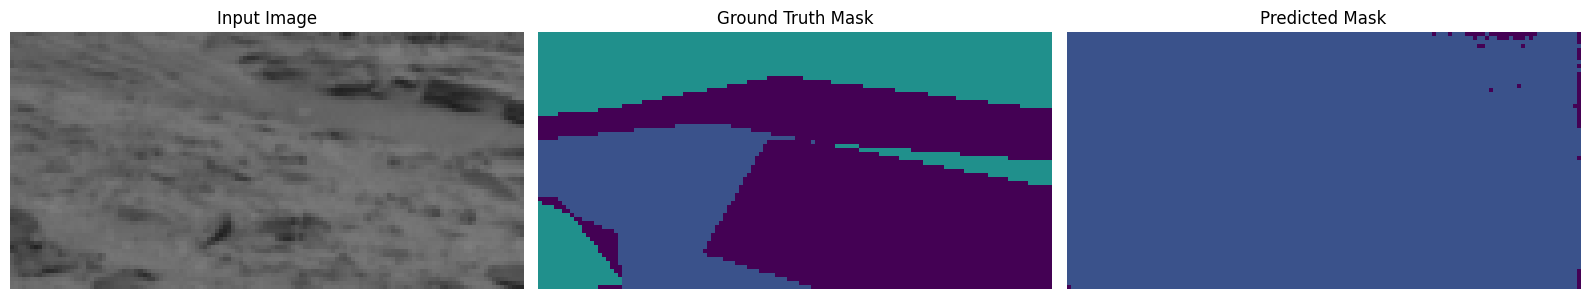

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy: 0.8046 - loss: 4.5181e-05 - mean_iou: 0.5264 - val_accuracy: 0.6762 - val_loss: 0.0347 - val_mean_iou: 0.3471 - learning_rate: 5.1840e-05
Epoch 57/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 504ms/step - accuracy: 0.7988 - loss: 8.4344e-05 - mean_iou: 0.5330 - val_accuracy: 0.6860 - val_loss: 0.0262 - val_mean_iou: 0.3915 - learning_rate: 5.1840e-05
Epoch 58/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - accuracy: 0.8008 - loss: 7.1261e-05 - mean_iou: 0.5400 - val_accuracy: 0.7257 - val_loss: 0.0214 - val_mean_iou: 0.4368 - learning_rate: 5.1840e-05
Epoch 59/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 502ms/step - accuracy: 0.8118 - loss: 5.1468e-05 - mean_iou: 0.5465 - val_accuracy: 0.7271 - val_loss: 0.0162 - val_mean_iou: 0.4094 - learning_rate: 3.7325e-05
Epoch 60/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - accuracy: 0.8184 - loss: 6.1876e-05 - mean_iou: 0.5412 - val_accuracy: 0.7243 - val_loss: 0.0211 - val_mean_iou: 0.4332 - learning_r

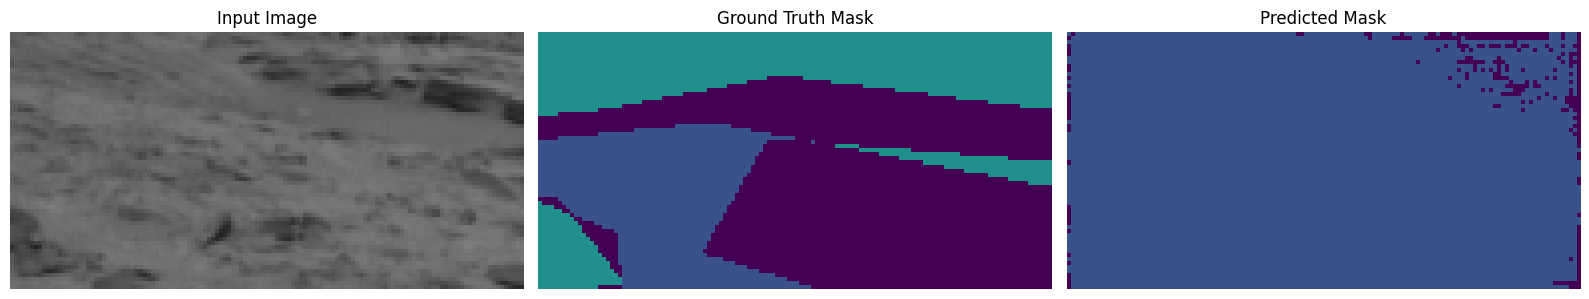

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.8144 - loss: 2.0579e-05 - mean_iou: 0.5471 - val_accuracy: 0.7234 - val_loss: 0.0222 - val_mean_iou: 0.4349 - learning_rate: 3.7325e-05
Epoch 62/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 515ms/step - accuracy: 0.8294 - loss: 4.6472e-05 - mean_iou: 0.5663 - val_accuracy: 0.7125 - val_loss: 0.0283 - val_mean_iou: 0.4149 - learning_rate: 3.7325e-05
Epoch 63/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - accuracy: 0.8330 - loss: 2.1084e-05 - mean_iou: 0.5614 - val_accuracy: 0.7495 - val_loss: 0.0177 - val_mean_iou: 0.4795 - learning_rate: 3.7325e-05
Epoch 64/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy: 0.8280 - loss: 4.3185e-05 - mean_iou: 0.5652 - val_accuracy: 0.7060 - val_loss: 0.0278 - val_mean_iou: 0.4115 - learning_rate: 3.7325e-05
Epoch 65/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 504ms/step - accuracy: 0.8223 - loss: 3.0393e-05 - mean_iou: 0.5621 - val_accuracy: 0.6518 - val_loss: 0.0484 - val_mean_iou: 0.3417 - learning_r

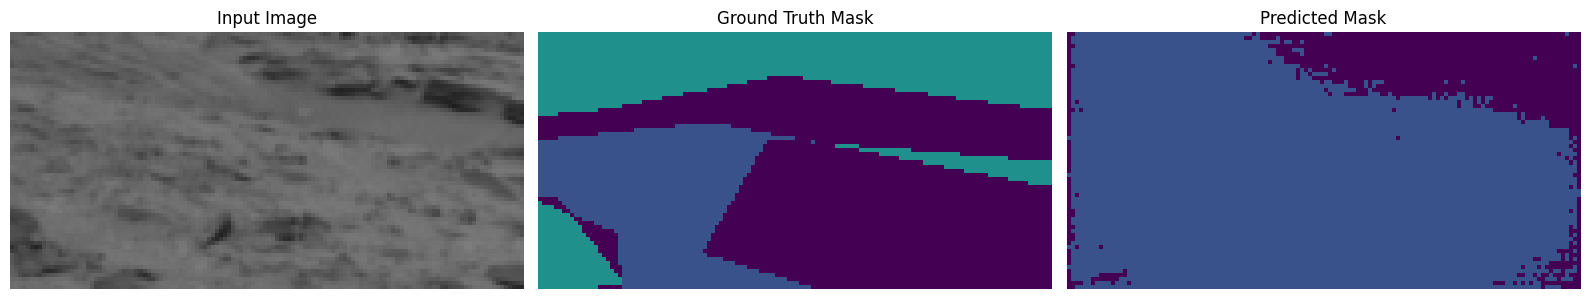

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy: 0.8336 - loss: 6.4340e-05 - mean_iou: 0.5598 - val_accuracy: 0.7356 - val_loss: 0.0207 - val_mean_iou: 0.4375 - learning_rate: 3.7325e-05
Epoch 67/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - accuracy: 0.8461 - loss: 1.5863e-05 - mean_iou: 0.5835 - val_accuracy: 0.7060 - val_loss: 0.0300 - val_mean_iou: 0.4155 - learning_rate: 2.6874e-05
Epoch 68/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 514ms/step - accuracy: 0.8498 - loss: 3.5411e-05 - mean_iou: 0.5916 - val_accuracy: 0.7066 - val_loss: 0.0307 - val_mean_iou: 0.4214 - learning_rate: 2.6874e-05
Epoch 69/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.8481 - loss: 4.0474e-05 - mean_iou: 0.5786 - val_accuracy: 0.7287 - val_loss: 0.0212 - val_mean_iou: 0.4573 - learning_rate: 2.6874e-05
Epoch 70/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.8357 - loss: 3.5427e-05 - mean_iou: 0.5656 - val_accuracy: 0.7199 - val_loss: 0.0290 - val_mean_iou: 0.4080 - learning_r

In [ ]:
history = superUnet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint1, viz_callback],
    class_weight=class_weights_dict
)

superUnet.save('superUNET.keras')
del superUnet

In [ ]:
# prompt: Genera delle previsioni in "preds" di X_test. Dato il limite di RAM, suddividi il X_test in più batches. Prima deve predire unet1 e poi unet 2. Entrambi devono essere caricati e compilati

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk

# Assuming X_test, BATCH_SIZE, input_shape, and NUM_CLASSES are defined

# Load the saved models
superUnet = tfk.models.load_model('superUNET.keras', compile=False)
superUnet.load_weights('superUNET.keras')

superUnet.compile(
        optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
        loss=lambda y_true, y_pred: combined_loss(y_true, y_pred),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)


preds = []
batch_size = BATCH_SIZE
for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i + batch_size]

    # Prediction with unet2
    pred2 = superUnet.predict(batch)

    preds.extend(pred2)

preds = np.array(preds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━

# BUILD

In [ ]:
data = np.load("no_alien_dataset_3colors.npz")

X_test = data["test_set"]
X_test = X_test[...] / 255.0
del data

In [ ]:
# prompt: Genera delle previsioni in "preds" di X_test. Dato il limite di RAM, suddividi il X_test in più batches. Prima deve predire unet1 e poi unet 2. Entrambi devono essere caricati e compilati

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk

# Assuming X_test, BATCH_SIZE, input_shape, and NUM_CLASSES are defined

# Load the saved models
unet1 = tfk.models.load_model('unet1_model.keras', compile=False)
unet2 = tfk.models.load_model('unet2_model.keras', compile=False)
unet1.load_weights('UNET1.keras')
unet2.load_weights('UNET2.keras')

# Recompile the models (necessary after loading)
unet1.compile(optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.10),
              metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])])

unet2.compile(optimizer=tfk.optimizers.AdamW(learning_rate=LEARNING_RATE),
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=1, boundary_weight=0.20),
              metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])])


preds = []
batch_size = BATCH_SIZE
for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i + batch_size]

    # Prediction with unet1
    pred1 = unet1.predict(batch)

    # Combine input and prediction for unet2
    combined_input = np.concatenate((batch, pred1), axis=-1)

    # Prediction with unet2
    pred2 = unet2.predict(combined_input)

    preds.extend(pred2)

preds = np.array(preds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/ste

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
print(preds.shape)

(10022, 64, 128, 5)


In [ ]:
# prompt: Controlla se le previsioni sono in one hot encoding. Se si, convertile in normali

# Check if predictions are in one-hot encoding
if preds.shape[-1] == NUM_CLASSES and np.any(np.sum(preds, axis=-1) != 1):
    # Convert one-hot encoded predictions to class labels
    preds = np.argmax(preds, axis=-1)

# Now preds contains class labels instead of one-hot encoded vectors
print(preds.shape)

(10022, 64, 128)


In [ ]:
submission_filename = f"submission_complesso.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [ ]:

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>